# **DLAI PROJECT Team 4**

# **Activity 1: Convolutional Autoencoder**

Steps:
1. Load MNIST train and test sets. Split the original training data into 95% training and 5% validation data.
2. Implement a convolutional autoencoder (with separate Encoder and Decoder modules).
3. Train the convolutional autoencoder, with different bottleneck sizes. 
Plot the train and validation loss curves of all autoencoders in the same figure.
4. Compute the avg. image reconstruction error (MSE) of the trained models on the MNIST validation and test sets. 
Show the results in a table, including #params of each model.
5. Select one of the autoencoders and feed it 5 random MNIST images from the test set. Show them along with their reconstructions.
6. Generate 5 new images by injecting random values as input to the decoder. Show them.


Libraries and imports

In [0]:
import torch
import copy
import random
import statistics 
import numpy as np
np.random.seed(7) # To obtain reproducible results
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(1)
import torch.nn.functional as F
import matplotlib.pyplot as plt
#%matplotlib inline
from torchvision import datasets, transforms
from tabulate import tabulate


Used constants

In [0]:
TraiSetSize = 60000
SplitTraning = 95
SplitTraningSize = int(TraiSetSize*SplitTraning/100)
SpitValidationSize = TraiSetSize-SplitTraningSize

Hyper-parameters definition

In [0]:
hparams = {
    'batch_size':64,
    'num_epochs':10,
    'test_batch_size':64,
    'eval_batch_size': 64,
    'hidden_size':128,
    'num_classes':10,
    'num_inputs':784,
    'learning_rate':1e-3,
    'log_interval':100,
    'bottleneck':30,
    'NumImages':5,
    'ex2_batch_size':100
}
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.manual_seed_all(7)

### **1. Load MNIST train and test sets. Split the original training data into 95%** 

Load MNIST train and test sets

In [5]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))
                                ]))

mnist_valset =copy.deepcopy(mnist_trainset)

mnist_testset = datasets.MNIST('data', train=False, 
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (0.5,))
                               ]))


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


Splitting the data into training (95%) and validation (5%)

In [0]:
mnist_trainset.data = mnist_trainset.data[:SplitTraningSize]
mnist_trainset.targets = mnist_trainset.targets[:SplitTraningSize]

mnist_valset.data = mnist_valset.data[SplitTraningSize:TraiSetSize]
mnist_valset.targets = mnist_valset.targets[SplitTraningSize:TraiSetSize]


Data loaders

In [0]:
train_loader = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=hparams['batch_size'], 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    mnist_testset,
    batch_size=hparams['test_batch_size'], 
    shuffle=False)

val_loader = torch.utils.data.DataLoader(
    mnist_valset,
    batch_size=hparams['eval_batch_size'], 
    shuffle=True)

Lets verify that the split has done correctly by printing each shape

In [8]:
print(mnist_trainset.data.shape)
print(mnist_trainset.targets.shape)

print(mnist_valset.data.shape)
print(mnist_valset.targets.shape)

torch.Size([57000, 28, 28])
torch.Size([57000])
torch.Size([3000, 28, 28])
torch.Size([3000])


### **2. Implement a convolutional autoencoder (with separate Encoder and Decoder modules).**

Encoder

In [0]:
class ConvEncoder(nn.Module):
  def __init__(self,bottlenecksize):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
    self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.linear1=nn.Linear(7*7*4, bottlenecksize)
    self.tanh=nn.Tanh()

  def forward(self,x):

    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x) 
    bsz, nch, height, width = x.shape
    x=x.view(bsz,-1)
    x=self.linear1(x)
    encoded=self.tanh(x)

    return encoded


Decoder

In [0]:
class ConvDecoder(nn.Module):
  def __init__(self,bottlenecksize=hparams['bottleneck']):
     super().__init__()

     self.linear1=nn.Linear(bottlenecksize, 7*7*4)
     self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
     self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)
     self.tanh=nn.Tanh()

  def forward(self,x):

    x=self.linear1(x)
    upSize=x.size()
    x=x.view(upSize[0], 4, 7, 7)
    x = F.relu(self.t_conv1(x))
    x=self.t_conv2(x)
    decoded=self.tanh(x)
    return decoded

Autoencoder

In [0]:
class ConvAutoencoder(nn.Module):
  def __init__(self, enc, dec):
    super().__init__()

    self.cEnc = enc
    self.cDec = dec

  def forward(self, x):

    x = self.cEnc(x)
    decoded = self.cDec(x)
    return decoded

### **3. Train the convolutional autoencoder, with different bottleneck sizes. Plot the train and validation loss curves of all autoencoders in the same figure.**
### **4. Compute the avg. image reconstruction error (MSE) of the trained models on the MNIST validation and test sets. Show the results in a table, including #params of each model.**

Bottleneck sizes

In [0]:
Neck_Sizes = [3,5,30,15]
NumNeckSizes = len(Neck_Sizes)

Definition of arrays where we are going to save for each bottleneck size:


*   Model --> model_trained
*   Training loss curve --> GlobalTrainHistory
*   Validation loss curve --> GlobalValidationHistory
*   Number of iteration after epoch --> GlobalValidationIndex






In [0]:
n_epochs = hparams['num_epochs']
model_trained = []
GlobalTrainHistory = []
GlobalValidationIndex = []
GlobalValidationHistory = []

Training for each bottleneck sizes

In [14]:
for i in range (NumNeckSizes):
  cEncoder=ConvEncoder(Neck_Sizes[i])
  cDecoder=ConvDecoder(Neck_Sizes[i])
  model = ConvAutoencoder(cEncoder, cDecoder)

  criterion = nn.MSELoss()
  optimizer = torch.optim.RMSprop(model.parameters(), lr=hparams['learning_rate'])

  train_history = []
  val_history = []
  test_history = []

  train_hist_epoch_cnt = 0
  train_hist_epoch_indx = []

  model_parameters = filter(lambda p: p.requires_grad, model.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
 
  print('\n\nBottleneck size:' + str(Neck_Sizes[i]) + '\nParameters: ' + str(params)+'\n')
  print ("Epoch\t\tTest error(avg)\t\tValidation error(avg)")
  print ("-----------------------------------------------------------------------")

  for epoch in range(1, n_epochs+1):

      train_loss = 0.0
      
      ###################
      # train the model #
      ###################
      for data in train_loader:
          
          images, _ = data
          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, images)
          loss.backward()
          optimizer.step()

          train_history.append(loss.item())
          train_loss += loss.item()*images.size(0)
          train_hist_epoch_cnt = train_hist_epoch_cnt + 1

      train_hist_epoch_indx.append(train_hist_epoch_cnt)  
      
      #########################################
      # apply the validaton data to the model #
      #########################################
      val_loss = 0.0
      for data2 in val_loader:
          images2, _ = data2
          outputs = model(images2)

          loss = criterion(outputs, images2)
          val_loss += loss.item()*images2.size(0)
      
      val_loss = round(val_loss/len(val_loader),3)
      val_history.append(loss.item())
   
      #########################################
      # apply the test data to the model #
      #########################################
      test_loss = 0.0
      for data3 in test_loader:
          images3, _ = data3
          outputs = model(images3)

          loss = criterion(outputs, images3)
          test_loss += loss.item()*images3.size(0)

      
      test_loss = round(test_loss/len(test_loader),3)
      test_history.append(test_loss)

      # Print Test MSE
      print('{}'.format(epoch) + '\t\t' + '{0:.3f}'.format(test_loss)+ '\t\t\t' + '{0:.3f}'.format(val_loss))

  # Save the learned model with the currect bottle neck on a model list
  model_trained.append(model)
  
  GlobalTrainHistory.append(train_history)
  GlobalValidationHistory.append(val_history)
  GlobalValidationIndex.append(train_hist_epoch_indx)





Bottleneck size:3
Parameters: 2452

Epoch		Test error(avg)		Validation error(avg)
-----------------------------------------------------------------------
1		17.242			17.102
2		13.367			13.381
3		12.552			12.507
4		12.222			12.194
5		12.148			12.178
6		11.915			11.940
7		11.841			11.807
8		11.739			11.790
9		11.689			11.734
10		11.707			11.736


Bottleneck size:5
Parameters: 3238

Epoch		Test error(avg)		Validation error(avg)
-----------------------------------------------------------------------
1		17.268			17.127
2		12.009			11.977
3		10.808			10.814
4		10.353			10.362
5		9.918			9.968
6		9.744			9.780
7		9.574			9.625
8		9.479			9.536
9		9.397			9.447
10		9.346			9.354


Bottleneck size:30
Parameters: 13063

Epoch		Test error(avg)		Validation error(avg)
-----------------------------------------------------------------------
1		8.295			8.498
2		5.475			5.672
3		4.581			4.704
4		4.152			4.333
5		3.654			3.815
6		3.442			3.587
7		3.316			3.475
8		3.193			3.346
9		3.051			3.198
10		2

Plotting of train and validation loss curves of all autoencoders

Text(0, 0.5, 'NLLLoss')

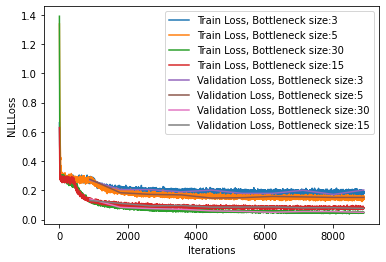

In [15]:
for i in range (NumNeckSizes):
  plt.plot(GlobalTrainHistory[i], label='Train Loss, Bottleneck size:' + str(Neck_Sizes[i]))

for i in range (NumNeckSizes):
  plt.plot(GlobalValidationIndex[i],GlobalValidationHistory[i], label='Validation Loss, Bottleneck size:' + str(Neck_Sizes[i]))

plt.legend()
plt.xlabel('Iterations')
plt.ylabel('NLLLoss')

### **5. Select one of the autoencoders and feed it 5 random MNIST images from the test set. Show them along with their reconstructions.**

Select the index of Neck_Sizes (position in the array of the bottleneck sizes we are goint to use)
Definition of the autoencoder we are going to use

In [0]:
ChooseModelInd = 3 #Bottleneck size = 15
ChooseModel =model_trained[ChooseModelInd]

Selection of 5 random MNIST images from the test set

In [17]:
n = hparams['NumImages']

dataiter = iter(test_loader)
images, labels = dataiter.next()
ps=abs(np.random.random_integers(images.shape[0])-n)
images= images.data[ps:ps+n]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. Please call randint(1, 64 + 1) instead
  """


Feed our autoencoder with the selected test set images and plot comparison

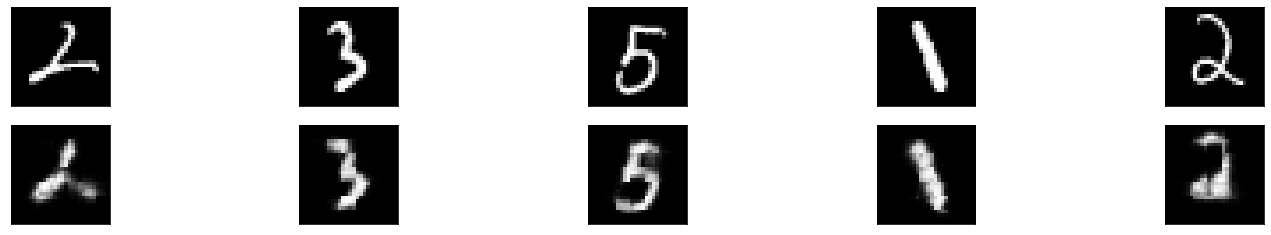

In [18]:
output = ChooseModel(images)

images = images.numpy()

output = output.view(n, 1, 28, 28)
output = output.detach().numpy()

fig, axes = plt.subplots(nrows=2, ncols=n, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images+ps, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

### **6. Generate 5 new images by injecting random values as input to the decoder. Show them.**

Generation of random values that we will use as input to the decoder (random values between logical interval at the output of our encoder)

In [19]:
x=torch.tensor(torch.FloatTensor(1,Neck_Sizes[ChooseModelInd]).normal_(0,0.5))
for i in range (hparams['batch_size']-1):
  x= torch.cat([x, torch.FloatTensor(1,Neck_Sizes[ChooseModelInd]).normal_(0, 0.5)], dim=0) 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


Injection of these random input to the decoder

In [0]:
output = ChooseModel.cDec(x)
output = output.detach().numpy()

Plotting of images that provide our decoder after injecting random input

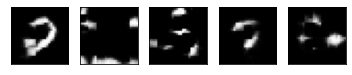

In [21]:
for i in range(n):
    # display reconstruction
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(output[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# **Activity 2: Transfer Learning**

Steps:
1. Select a subset of 100 images and their associated labels from the MNIST training data.
2. Select one of the previously trained autoencoders.
3. Create a digit (0-9) classification model reusing the encoder of the autoencoder and adding the needed fully connected (projection) layer.
4. Pre-training: use the weights of the autoencoder as initial values for the network weights and train a classification model on the subset of 100 samples.
5. Fine-tuning: do the same, but train the new projection layer with a normal learning rate and the reused part with a very low learning rate.
6. From scratch: train the model on the 100 samples without reusing the encoder weights at all.
7. Show the accuracy of the three models on the MNIST test set in a table.


### **1. Select a subset of 100 images and their associated labels from the MNIST training data.**

In [22]:
# Create a copy to not trim the original trainset
mnist_traindata =copy.deepcopy(mnist_trainset)

ps=abs(np.random.random_integers(mnist_traindata.data.shape[0]-100))

mnist_traindata.data = mnist_traindata.data[ps:ps+100]
mnist_traindata.targets = mnist_traindata.targets[ps:ps+100]

traind_loader = torch.utils.data.DataLoader(
    mnist_traindata,
    batch_size=hparams['ex2_batch_size'], 
    shuffle=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(1, 56900 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until


Verification of the selected subset shape

In [23]:
print(mnist_traindata.data.shape)
print(mnist_traindata.targets.shape)

torch.Size([100, 28, 28])
torch.Size([100])


In [24]:
iter_ = iter(traind_loader)
bimg, blabel = next(iter_)
print('Batch Img shape: ', bimg.shape)
print('Batch Label shape: ', blabel.shape)
print('The Batched tensors return a collection of {} grayscale images ({} channel, {} height pixels, {} width pixels)'.format(bimg.shape[0],
                                                                                                                              bimg.shape[1],
                                                                                                                              bimg.shape[2],
                                                                                                                              bimg.shape[3]))

Batch Img shape:  torch.Size([100, 1, 28, 28])
Batch Label shape:  torch.Size([100])
The Batched tensors return a collection of 100 grayscale images (1 channel, 28 height pixels, 28 width pixels)


### **2. Select one of the previously trained autoencoders.**

In [0]:
Autoencoder = ChooseModel

### **3. Create a digit (0-9) classification model reusing the encoder of the autoencoder and adding the needed fully connected (projection) layer.**

Classificator

In [0]:
class Clasificator(nn.Module):
  def __init__(self,bottlenecksize):
    super().__init__()
    self.linear1=nn.Linear(bottlenecksize, hparams['hidden_size'])
    self.linear2=nn.Linear(hparams['hidden_size'], hparams['num_classes'])
    self.logsoftmax=nn.LogSoftmax()

  def forward(self,x):
    x = self.linear1(x)
    x = F.relu(x)
    x = self.linear2(x)
    clasif = self.logsoftmax(x)

    return clasif

Classification model created by reusing the encoder and adding the fully connected layer

In [0]:
class ClasificationModel(nn.Module):
  def __init__(self, enc, clasif):
    super().__init__()

    self.cEnc = enc
    self.cClasif = clasif

  def forward(self, x):

    x = self.cEnc(x)
    Clasified = self.cClasif(x)

    return Clasified

### **4. Pre-training: use the weights of the autoencoder as initial values for the network weights and train a classification model on the subset of 100 samples.**

Choose the model we are going to use

In [0]:
cClasificator = Clasificator(Neck_Sizes[ChooseModelInd])
PreTraining_model = ClasificationModel(Autoencoder.cEnc, cClasificator)

Define criterion and optimizer and average weight

In [0]:
criterion=F.nll_loss
optimizer=optim.RMSprop(params=PreTraining_model.parameters(), lr=hparams['learning_rate'], alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
avg_loss = None
avg_weight = 0.1

Definition of the funtion that returns the accuracy of the prediction

In [0]:
def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

Training function definition

In [0]:
def train_epoch(train_loader, network, optimizer, criterion, hparams):
  network.train()
  device = hparams['device']
  avg_loss = None
  avg_weight = 0.1
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      network=network.to(device)
      optimizer.zero_grad()
      output = network(data)
      loss = criterion(output, target)
      loss.backward()
      if avg_loss:
        avg_loss = avg_weight * loss.item() + (1 - avg_weight) * avg_loss
      else:
        avg_loss = loss.item()
      optimizer.step()
      if batch_idx % hparams['log_interval'] == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
  return avg_loss

Testing function definition

In [0]:
def test_epoch(test_loader, network, hparams):
    network.eval()
    device = hparams['device']
    test_loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            network=network.to(device)
            output = network(data)
            test_loss += criterion(output, target, reduction='sum').item() 
            acc += correct_predictions(output, target)
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * acc / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, acc, len(test_loader.dataset), test_acc,
        ))
    return test_loss, test_acc

Training

In [33]:
train_losses = []
test_losses = []
test_accs_1 = []

for epoch in range(1, hparams['num_epochs'] + 1):
  train_losses.append(train_epoch(traind_loader, PreTraining_model, optimizer, criterion, hparams))

  test_loss,test_accuracy=test_epoch(test_loader, PreTraining_model, hparams)
  
  test_losses.append(test_loss)
  test_accs_1.append(test_accuracy)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Train Epoch: 1 [0/100 (0%)]	Loss: 2.320505

Test set: Average loss: 2.2759, Accuracy: 1291/10000 (13%)

Train Epoch: 2 [0/100 (0%)]	Loss: 2.261381

Test set: Average loss: 2.2075, Accuracy: 2153/10000 (22%)

Train Epoch: 3 [0/100 (0%)]	Loss: 2.166600

Test set: Average loss: 2.1078, Accuracy: 3202/10000 (32%)

Train Epoch: 4 [0/100 (0%)]	Loss: 2.026055

Test set: Average loss: 1.9718, Accuracy: 4473/10000 (45%)

Train Epoch: 5 [0/100 (0%)]	Loss: 1.853849

Test set: Average loss: 1.8566, Accuracy: 4614/10000 (46%)

Train Epoch: 6 [0/100 (0%)]	Loss: 1.686731

Test set: Average loss: 1.7488, Accuracy: 4949/10000 (49%)

Train Epoch: 7 [0/100 (0%)]	Loss: 1.559655

Test set: Average loss: 1.6967, Accuracy: 4740/10000 (47%)

Train Epoch: 8 [0/100 (0%)]	Loss: 1.445240

Test set: Average loss: 1.5527, Accuracy: 5798/10000 (58%)

Train Epoch: 9 [0/100 (0%)]	Loss: 1.302698

Test set: Average loss: 1.5087, Accuracy: 5415/10000 (54%)

Train Epoch: 10 [0/100 (0%)]	Loss: 1.182769

Test set: Average l

Plotting the obtained results

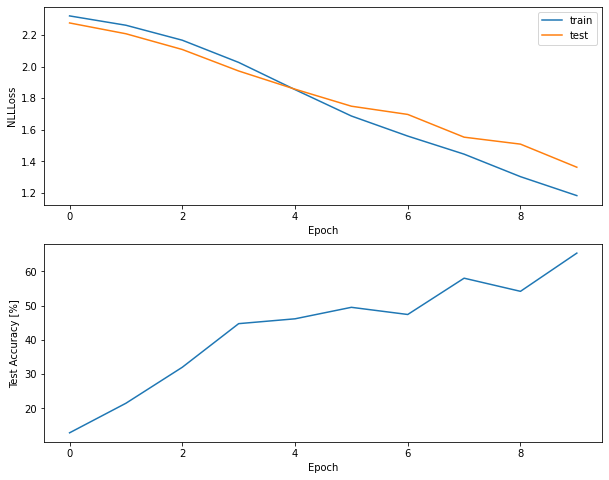

In [34]:
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('NLLLoss')

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.subplot(2,1,2)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy [%]')
plt.plot(test_accs_1)

### **5. Fine-tuning: do the same, but train the new projection layer with a normal learning rate and the reused part with a very low learning rate.**

First, we will define the Optimizer with different LR for each section of the model.

In [35]:
print(PreTraining_model.cEnc)
print(PreTraining_model.cClasif)

ConvEncoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=196, out_features=15, bias=True)
  (tanh): Tanh()
)
Clasificator(
  (linear1): Linear(in_features=15, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
)


In [0]:
optimizer = optim.RMSprop([
                {'params': PreTraining_model.cEnc.parameters()},
                {'params': PreTraining_model.cClasif.parameters(), 'lr': 1e-9}
            ], lr=hparams['learning_rate'] , momentum=0)

Now, we will try the model with the new LRs.

In [37]:
# Init lists to save the evolution of the training & test losses/accuracy.
train_losses = []
test_losses = []
test_accs_2 = []

for epoch in range(1, hparams['num_epochs'] + 1):
  train_losses.append(train_epoch(traind_loader, PreTraining_model, optimizer, criterion, hparams))

  test_loss,test_accuracy=test_epoch(test_loader, PreTraining_model, hparams)
  
  test_losses.append(test_loss)
  test_accs_2.append(test_accuracy)

Train Epoch: 1 [0/100 (0%)]	Loss: 1.046445


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':



Test set: Average loss: 1.5966, Accuracy: 4594/10000 (46%)

Train Epoch: 2 [0/100 (0%)]	Loss: 1.225509

Test set: Average loss: 1.3397, Accuracy: 6340/10000 (63%)

Train Epoch: 3 [0/100 (0%)]	Loss: 0.999766

Test set: Average loss: 1.3041, Accuracy: 6656/10000 (67%)

Train Epoch: 4 [0/100 (0%)]	Loss: 0.947318

Test set: Average loss: 1.2755, Accuracy: 6749/10000 (67%)

Train Epoch: 5 [0/100 (0%)]	Loss: 0.909694

Test set: Average loss: 1.2567, Accuracy: 6860/10000 (69%)

Train Epoch: 6 [0/100 (0%)]	Loss: 0.886915

Test set: Average loss: 1.2495, Accuracy: 6809/10000 (68%)

Train Epoch: 7 [0/100 (0%)]	Loss: 0.869913

Test set: Average loss: 1.2359, Accuracy: 6939/10000 (69%)

Train Epoch: 8 [0/100 (0%)]	Loss: 0.855978

Test set: Average loss: 1.2359, Accuracy: 6845/10000 (68%)

Train Epoch: 9 [0/100 (0%)]	Loss: 0.844522

Test set: Average loss: 1.2207, Accuracy: 6991/10000 (70%)

Train Epoch: 10 [0/100 (0%)]	Loss: 0.833407

Test set: Average loss: 1.2236, Accuracy: 6869/10000 (69%)



Plotting of the new results

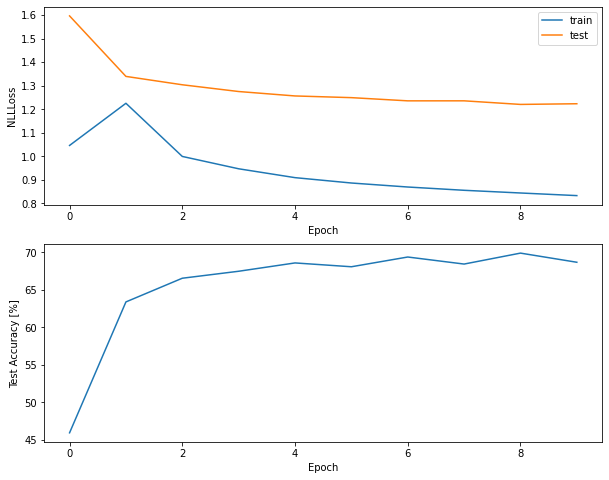

In [38]:
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('NLLLoss')

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.subplot(2,1,2)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy [%]')
plt.plot(test_accs_2)

### **6. From scratch: train the model on the 100 samples without reusing the encoder weights at all.**

First, intead of reusing the already trained encoder from Exercise 1, let's create a brand new ENCODER.

In [0]:
newEnc = ConvEncoder(Neck_Sizes[ChooseModelInd])

Now, lets add it to our new Classifier:

In [40]:
FromScratch_model = ClasificationModel(newEnc, cClasificator)
print(FromScratch_model)
optimizer=optim.RMSprop(params=FromScratch_model.parameters(), lr=hparams['learning_rate'], alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

ClasificationModel(
  (cEnc): ConvEncoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (linear1): Linear(in_features=196, out_features=15, bias=True)
    (tanh): Tanh()
  )
  (cClasif): Clasificator(
    (linear1): Linear(in_features=15, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=10, bias=True)
    (logsoftmax): LogSoftmax()
  )
)


Lets train the new model:

In [41]:
train_losses = []
test_losses = []
test_accs_3 = []

for epoch in range(1, hparams['num_epochs'] + 1):
  train_losses.append(train_epoch(traind_loader, FromScratch_model, optimizer, criterion, hparams))

  test_loss,test_accuracy=test_epoch(test_loader, FromScratch_model, hparams)
  
  test_losses.append(test_loss)
  test_accs_3.append(test_accuracy)

Train Epoch: 1 [0/100 (0%)]	Loss: 2.299904


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':



Test set: Average loss: 2.2825, Accuracy: 1090/10000 (11%)

Train Epoch: 2 [0/100 (0%)]	Loss: 2.218229

Test set: Average loss: 2.1439, Accuracy: 2916/10000 (29%)

Train Epoch: 3 [0/100 (0%)]	Loss: 2.074480

Test set: Average loss: 2.3470, Accuracy: 1048/10000 (10%)

Train Epoch: 4 [0/100 (0%)]	Loss: 2.198586

Test set: Average loss: 2.0991, Accuracy: 2363/10000 (24%)

Train Epoch: 5 [0/100 (0%)]	Loss: 1.993863

Test set: Average loss: 1.9446, Accuracy: 4834/10000 (48%)

Train Epoch: 6 [0/100 (0%)]	Loss: 1.813739

Test set: Average loss: 1.7525, Accuracy: 4105/10000 (41%)

Train Epoch: 7 [0/100 (0%)]	Loss: 1.548038

Test set: Average loss: 1.6039, Accuracy: 4891/10000 (49%)

Train Epoch: 8 [0/100 (0%)]	Loss: 1.344322

Test set: Average loss: 1.4732, Accuracy: 5338/10000 (53%)

Train Epoch: 9 [0/100 (0%)]	Loss: 1.177443

Test set: Average loss: 1.4706, Accuracy: 4624/10000 (46%)

Train Epoch: 10 [0/100 (0%)]	Loss: 1.130735

Test set: Average loss: 1.6184, Accuracy: 3927/10000 (39%)



Plotting the results:

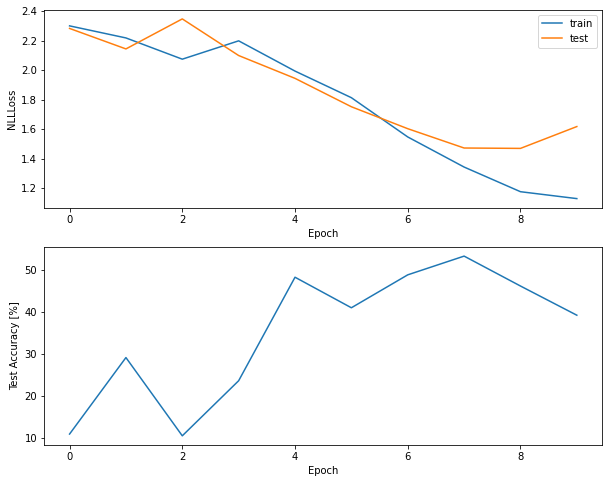

In [42]:
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('NLLLoss')

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.subplot(2,1,2)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy [%]')
plt.plot(test_accs_3)

### **7. Show the accuracy of the three models on the MNIST test set in a table.**

In [43]:
print(tabulate([["Model","Accuracy"],["Pre-Training",max(test_accs_1)],["Fine-Tunning",max(test_accs_2)],["From-Scratch",max(test_accs_3)]],headers="firstrow"))

Model           Accuracy
------------  ----------
Pre-Training       65.29
Fine-Tunning       69.91
From-Scratch       53.38


# Optional B: GAN
Steps:


1. Implement a generator and discriminator based con deconvolutions and convolutions respectively.

2. Train the GAN on MNIST.

3. Generate samples with the generator and show them.

**EXERCISE 1** Implement a generator and discriminator based con deconvolutions and convolutions respectively.

In [0]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

import torch
import random
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets, utils
from IPython.display import display
from PIL import Image
import numpy as np
import math

batch_size = 100

SOME UTILS WITH MINOR IMPORTANCE:

In [0]:
def norm_noise(size):
    return torch.cuda.FloatTensor(size, 100).normal_()

def rand_label():
    FT = torch.cuda.LongTensor
    return Variable(FT(np.random.randint(0, 10, batch_size)))


  
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)
  
def display_batch_images(img, imtype=np.uint8, unnormalize=True, nrows=None, mean=0.5, std=0.5):
    if len(img.shape) == 4:
        nrows = nrows if nrows is not None else int(math.sqrt(img.size(0)))
        img = utils.make_grid(img, nrow=nrows)

    img = img.cpu().float()    
    img = (img*std+mean)*255

    image_numpy = img.detach().numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    display(Image.fromarray(image_numpy.astype(imtype))) 

Import DATASET

In [0]:
def mnist():
    tf = transforms.Compose(
        [
            transforms.Resize(32, interpolation=0),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (.5,))
        ])
    return datasets.MNIST(root='./data/', train=True, transform=tf, download=True)

Lets create a DataLoader for the Mnist Dataset

In [0]:
data_loader = torch.utils.data.DataLoader(mnist(), batch_size=batch_size, shuffle=True)

Now, lets define the GENERATOR

In [0]:
class Generator(torch.nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        self.label_embed = nn.Embedding(10, 10)
        self._fc = torch.nn.Linear(100, 1024*4*4)
        self.Linear = torch.nn.Linear(100*110, 100*100)

        self._conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self._conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self._conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=1, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.Tanh()
        )

    def forward(self, x, labels3):
        x = torch.cat((self.label_embed(labels3), x), -1)
        x = x.view(-1, 100*110)
        x=self.Linear(x)
        x = x.view(100, 100)
        x = self._fc(x)        
        x = self._conv1(x.view(x.shape[0], 1024, 4, 4))
        x = self._conv2(x)
        x = self._conv3(x)
        return x


And now the DISCRIMINATOR

In [0]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.label_embed_d = nn.Embedding(10, 10)
        self.Pol = nn.MaxPool1d(1,1)

        self._conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self._conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self._fc = nn.Sequential(
            nn.Linear(512*4*4, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels2):
        x = self._conv1(x)
        x = self._conv2(x)
        x = self._conv3(x)

        return self._fc(x.view(-1, 512*4*4))

Lets create the MODEL

In [0]:
class Model:

    def __init__(self, batch_size):
        self._create_networks()
        self._create_optimizer()
        self._init_criterion(batch_size)
        
    def _create_networks(self):
        self._generator = Generator()
        self._discriminator = Discriminator()
        
        self._generator.apply(init_weights)
        self._discriminator.apply(init_weights)
        
        self._generator.cuda()
        self._discriminator.cuda()
        
    def _create_optimizer(self):
        self._opt_g = torch.optim.Adam(self._generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        self._opt_d = torch.optim.Adam(self._discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
    def _init_criterion(self, batch_size):
        self._criterion = nn.BCELoss()
        self._label_real = Variable(torch.ones(batch_size, 1)).cuda()
        self._label_fake = Variable(torch.zeros(batch_size, 1)).cuda()
        
    def generate_samples(self, batch_size):
        z = norm_noise(batch_size)
        gen_label = rand_label()
        fake_samples = self._generator(z,gen_label)
        return fake_samples, gen_label
    
    def step_optimization(self, real_samples, labels1):
        fake_samples, gen_label = self.generate_samples(real_samples.size(0))
        
        loss_g = self._step_opt_g(fake_samples, gen_label)
        
        loss_d = self._step_opt_d(real_samples, fake_samples.detach(), gen_label, labels1)
        
        return loss_g, loss_d
      
    def _step_opt_g(self, fake_samples, gen_label):
        self._opt_g.zero_grad()
        estim_fake = self._discriminator(fake_samples, gen_label)
        loss = self._criterion(estim_fake, self._label_real)
        loss.backward()
        self._opt_g.step()
        
        return loss.item()
        
    def _step_opt_d(self, real_samples, fake_samples, gen_label, labels1):
        self._opt_d.zero_grad()

        estim_real = self._discriminator(real_samples,labels1)
        loss_real = self._criterion(estim_real, self._label_real)

        estim_fake = self._discriminator(fake_samples, gen_label)
        loss_fake = self._criterion(estim_fake, self._label_fake)
        
        loss = (loss_real + loss_fake) / 2
        loss.backward()

        self._opt_d.step()

        return loss_real.item(), loss_fake.item()

**EXERCISE 2** Train the GAN on MNIST.


In [0]:
num_epochs = 10
num_val_samples = 100
model = Model(num_val_samples)

epoch: 0/10, batch: 0/600, G_loss: 0.6908761858940125, D_loss: (0.6862026453018188, 0.6954253315925598)


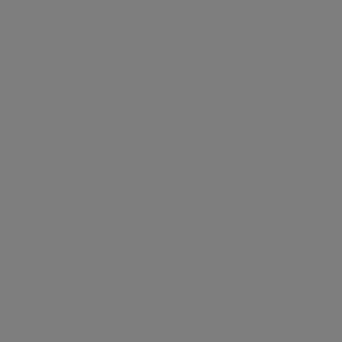

epoch: 0/10, batch: 10/600, G_loss: 0.6636375188827515, D_loss: (0.5755525827407837, 0.7236038446426392)
epoch: 0/10, batch: 20/600, G_loss: 0.8543775081634521, D_loss: (0.44861993193626404, 0.554400622844696)
epoch: 0/10, batch: 30/600, G_loss: 1.2368758916854858, D_loss: (0.3059443533420563, 0.3437443673610687)
epoch: 0/10, batch: 40/600, G_loss: 1.4826364517211914, D_loss: (0.20466867089271545, 0.2586233615875244)
epoch: 0/10, batch: 50/600, G_loss: 1.5873446464538574, D_loss: (0.14225946366786957, 0.2313249558210373)
epoch: 0/10, batch: 60/600, G_loss: 2.030256748199463, D_loss: (0.09348678588867188, 0.14163680374622345)
epoch: 0/10, batch: 70/600, G_loss: 2.528543472290039, D_loss: (0.07011983543634415, 0.08334071189165115)
epoch: 0/10, batch: 80/600, G_loss: 2.883899450302124, D_loss: (0.05126062035560608, 0.05763296037912369)
epoch: 0/10, batch: 90/600, G_loss: 3.0971617698669434, D_loss: (0.03936849907040596, 0.04662252962589264)
epoch: 0/10, batch: 100/600, G_loss: 3.354385137

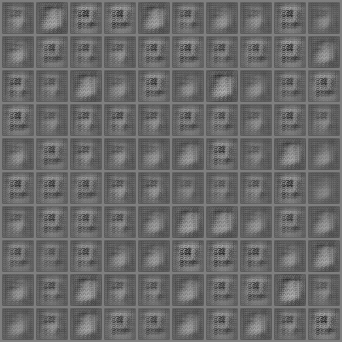

epoch: 0/10, batch: 110/600, G_loss: 1.696926236152649, D_loss: (0.02748025953769684, 0.2102089822292328)
epoch: 0/10, batch: 120/600, G_loss: 1.17714262008667, D_loss: (0.08115720003843307, 0.48415815830230713)
epoch: 0/10, batch: 130/600, G_loss: 2.186709403991699, D_loss: (0.22731663286685944, 0.13422594964504242)
epoch: 0/10, batch: 140/600, G_loss: 2.201251268386841, D_loss: (0.10046655684709549, 0.13988710939884186)
epoch: 0/10, batch: 150/600, G_loss: 2.7893688678741455, D_loss: (0.05569777637720108, 0.06785240769386292)
epoch: 0/10, batch: 160/600, G_loss: 1.6765530109405518, D_loss: (0.07242578268051147, 0.24949359893798828)
epoch: 0/10, batch: 170/600, G_loss: 3.7970664501190186, D_loss: (0.12872125208377838, 0.024276385083794594)
epoch: 0/10, batch: 180/600, G_loss: 2.7606775760650635, D_loss: (0.1924424022436142, 0.07394948601722717)
epoch: 0/10, batch: 190/600, G_loss: 1.9893170595169067, D_loss: (0.0590348057448864, 0.16999226808547974)
epoch: 0/10, batch: 200/600, G_loss

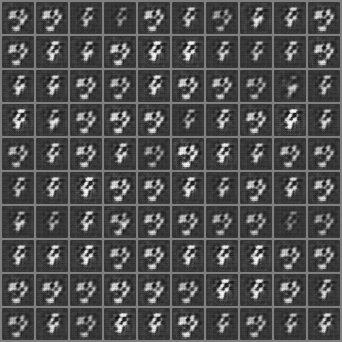

epoch: 0/10, batch: 210/600, G_loss: 1.8629072904586792, D_loss: (0.12394057214260101, 0.17748893797397614)
epoch: 0/10, batch: 220/600, G_loss: 1.9480689764022827, D_loss: (0.05250725895166397, 0.1632372885942459)
epoch: 0/10, batch: 230/600, G_loss: 0.425618439912796, D_loss: (0.020370379090309143, 1.1177067756652832)
epoch: 0/10, batch: 240/600, G_loss: 1.615433931350708, D_loss: (0.20369330048561096, 0.23199693858623505)
epoch: 0/10, batch: 250/600, G_loss: 2.146682024002075, D_loss: (0.07101403921842575, 0.12963052093982697)
epoch: 0/10, batch: 260/600, G_loss: 2.3760156631469727, D_loss: (0.03376692906022072, 0.10817929357290268)
epoch: 0/10, batch: 270/600, G_loss: 3.651517868041992, D_loss: (0.2111712396144867, 0.02738516591489315)
epoch: 0/10, batch: 280/600, G_loss: 2.5059163570404053, D_loss: (0.11567124724388123, 0.09018037468194962)
epoch: 0/10, batch: 290/600, G_loss: 1.938542127609253, D_loss: (0.03652395308017731, 0.27493155002593994)
epoch: 0/10, batch: 300/600, G_loss

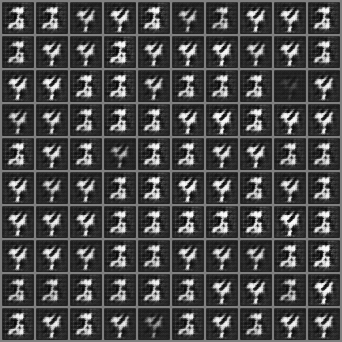

epoch: 0/10, batch: 310/600, G_loss: 2.9556612968444824, D_loss: (0.10463561117649078, 0.06268618255853653)
epoch: 0/10, batch: 320/600, G_loss: 4.9130048751831055, D_loss: (1.118812918663025, 0.007822375744581223)
epoch: 0/10, batch: 330/600, G_loss: 2.3457517623901367, D_loss: (0.15755370259284973, 0.11340266466140747)
epoch: 0/10, batch: 340/600, G_loss: 2.0685813426971436, D_loss: (0.043132033199071884, 0.24617087841033936)
epoch: 0/10, batch: 350/600, G_loss: 2.159485340118408, D_loss: (0.05823807418346405, 0.12298015505075455)
epoch: 0/10, batch: 360/600, G_loss: 1.3968766927719116, D_loss: (0.027335871011018753, 0.31619635224342346)
epoch: 0/10, batch: 370/600, G_loss: 1.822992205619812, D_loss: (0.07351746410131454, 0.18428044021129608)
epoch: 0/10, batch: 380/600, G_loss: 3.0180699825286865, D_loss: (0.23392799496650696, 0.05280632525682449)
epoch: 0/10, batch: 390/600, G_loss: 1.2529205083847046, D_loss: (0.02727203071117401, 0.36962831020355225)
epoch: 0/10, batch: 400/600, 

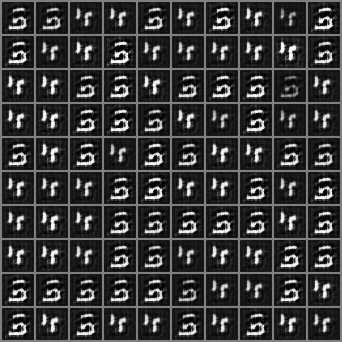

epoch: 0/10, batch: 410/600, G_loss: 2.898608922958374, D_loss: (0.0388135202229023, 0.06374876201152802)
epoch: 0/10, batch: 420/600, G_loss: 2.8292062282562256, D_loss: (0.02589826099574566, 0.06188330054283142)
epoch: 0/10, batch: 430/600, G_loss: 1.1018396615982056, D_loss: (0.10565779358148575, 0.42057475447654724)
epoch: 0/10, batch: 440/600, G_loss: 2.084559917449951, D_loss: (0.12357082962989807, 0.14914818108081818)
epoch: 0/10, batch: 450/600, G_loss: 2.0931308269500732, D_loss: (0.062215086072683334, 0.1332559734582901)
epoch: 0/10, batch: 460/600, G_loss: 2.978689193725586, D_loss: (0.11918453872203827, 0.056759461760520935)
epoch: 0/10, batch: 470/600, G_loss: 1.5693734884262085, D_loss: (0.03286019712686539, 0.2422035038471222)
epoch: 0/10, batch: 480/600, G_loss: 1.698266863822937, D_loss: (0.03524698689579964, 0.20532864332199097)
epoch: 0/10, batch: 490/600, G_loss: 3.480221748352051, D_loss: (0.06118862330913544, 0.03449077159166336)
epoch: 0/10, batch: 500/600, G_los

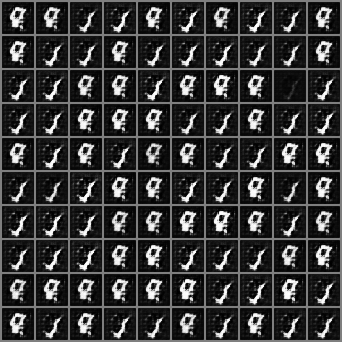

epoch: 0/10, batch: 510/600, G_loss: 2.262467384338379, D_loss: (0.1858702301979065, 0.1131947785615921)
epoch: 0/10, batch: 520/600, G_loss: 1.2329108715057373, D_loss: (0.06341352313756943, 0.3502615988254547)
epoch: 0/10, batch: 530/600, G_loss: 2.4062540531158447, D_loss: (0.09246518462896347, 0.0976577028632164)
epoch: 0/10, batch: 540/600, G_loss: 0.6388939023017883, D_loss: (0.021184206008911133, 0.7619325518608093)
epoch: 0/10, batch: 550/600, G_loss: 2.069544792175293, D_loss: (0.11506438255310059, 0.14064572751522064)
epoch: 0/10, batch: 560/600, G_loss: 3.501631498336792, D_loss: (0.06051063537597656, 0.14318685233592987)
epoch: 0/10, batch: 570/600, G_loss: 2.424290657043457, D_loss: (0.05358874425292015, 0.10025186836719513)
epoch: 0/10, batch: 580/600, G_loss: 2.251678466796875, D_loss: (0.11572632193565369, 0.11802169680595398)
epoch: 0/10, batch: 590/600, G_loss: 3.206759452819824, D_loss: (0.13782335817813873, 0.0472152978181839)
epoch: 1/10, batch: 0/600, G_loss: 2.43

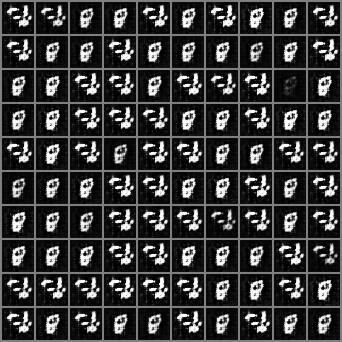

epoch: 1/10, batch: 10/600, G_loss: 3.015449285507202, D_loss: (0.023497430607676506, 0.08759626746177673)
epoch: 1/10, batch: 20/600, G_loss: 1.811000943183899, D_loss: (0.12862646579742432, 0.1847088634967804)
epoch: 1/10, batch: 30/600, G_loss: 2.5826480388641357, D_loss: (0.08657173067331314, 0.07970168441534042)
epoch: 1/10, batch: 40/600, G_loss: 4.013800144195557, D_loss: (0.14594914019107819, 0.024063806980848312)
epoch: 1/10, batch: 50/600, G_loss: 3.714012384414673, D_loss: (0.120921790599823, 0.024762747809290886)
epoch: 1/10, batch: 60/600, G_loss: 2.7083446979522705, D_loss: (0.05349045619368553, 0.07459346204996109)
epoch: 1/10, batch: 70/600, G_loss: 3.7550439834594727, D_loss: (0.009250988252460957, 0.2009372115135193)
epoch: 1/10, batch: 80/600, G_loss: 3.3577466011047363, D_loss: (0.031976472586393356, 0.058816149830818176)
epoch: 1/10, batch: 90/600, G_loss: 3.534111976623535, D_loss: (0.108766108751297, 0.03006872721016407)
epoch: 1/10, batch: 100/600, G_loss: 4.211

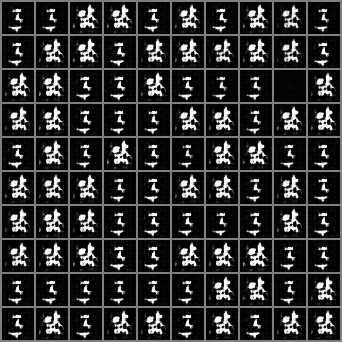

epoch: 1/10, batch: 110/600, G_loss: 6.544132232666016, D_loss: (1.0679072141647339, 0.0026088824961334467)
epoch: 1/10, batch: 120/600, G_loss: 3.0385472774505615, D_loss: (0.14790870249271393, 0.051094818860292435)
epoch: 1/10, batch: 130/600, G_loss: 3.9421510696411133, D_loss: (0.14525091648101807, 0.019817456603050232)
epoch: 1/10, batch: 140/600, G_loss: 2.6308014392852783, D_loss: (0.07135894894599915, 0.07605697959661484)
epoch: 1/10, batch: 150/600, G_loss: 2.8850014209747314, D_loss: (0.07764716446399689, 0.060432519763708115)
epoch: 1/10, batch: 160/600, G_loss: 2.569758892059326, D_loss: (0.037747178226709366, 0.09886680543422699)
epoch: 1/10, batch: 170/600, G_loss: 2.9493513107299805, D_loss: (0.06869979202747345, 0.055908963084220886)
epoch: 1/10, batch: 180/600, G_loss: 2.0879926681518555, D_loss: (0.26392993330955505, 0.14259400963783264)
epoch: 1/10, batch: 190/600, G_loss: 2.757603168487549, D_loss: (0.1209029108285904, 0.06703980267047882)
epoch: 1/10, batch: 200/60

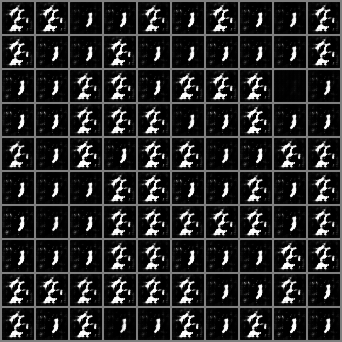

epoch: 1/10, batch: 210/600, G_loss: 0.978843092918396, D_loss: (0.02754751220345497, 0.4896003007888794)
epoch: 1/10, batch: 220/600, G_loss: 3.5643372535705566, D_loss: (0.4345815181732178, 0.030667727813124657)
epoch: 1/10, batch: 230/600, G_loss: 2.6590099334716797, D_loss: (0.2335699051618576, 0.07977645099163055)
epoch: 1/10, batch: 240/600, G_loss: 2.7872703075408936, D_loss: (0.0660613551735878, 0.06667093932628632)
epoch: 1/10, batch: 250/600, G_loss: 6.656801700592041, D_loss: (0.487039715051651, 0.004515914246439934)
epoch: 1/10, batch: 260/600, G_loss: 2.7068514823913574, D_loss: (0.11424561589956284, 0.07375966757535934)
epoch: 1/10, batch: 270/600, G_loss: 2.8869736194610596, D_loss: (0.1469995379447937, 0.08221621811389923)
epoch: 1/10, batch: 280/600, G_loss: 4.746610641479492, D_loss: (0.19844940304756165, 0.012517961673438549)
epoch: 1/10, batch: 290/600, G_loss: 2.5847432613372803, D_loss: (0.13481150567531586, 0.09388604015111923)
epoch: 1/10, batch: 300/600, G_loss

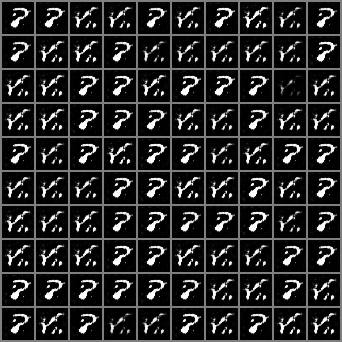

epoch: 1/10, batch: 310/600, G_loss: 2.196002721786499, D_loss: (0.11876832693815231, 0.12266457825899124)
epoch: 1/10, batch: 320/600, G_loss: 4.0084404945373535, D_loss: (0.09340701997280121, 0.08382991701364517)
epoch: 1/10, batch: 330/600, G_loss: 1.5191981792449951, D_loss: (0.12317634373903275, 0.32580453157424927)
epoch: 1/10, batch: 340/600, G_loss: 3.1011879444122314, D_loss: (0.13440226018428802, 0.04690951481461525)
epoch: 1/10, batch: 350/600, G_loss: 5.167286396026611, D_loss: (0.2259347140789032, 0.006104194559156895)
epoch: 1/10, batch: 360/600, G_loss: 3.0342319011688232, D_loss: (0.12803000211715698, 0.05463266745209694)
epoch: 1/10, batch: 370/600, G_loss: 0.643764317035675, D_loss: (0.026744410395622253, 0.8053547739982605)
epoch: 1/10, batch: 380/600, G_loss: 3.968158006668091, D_loss: (0.5802374482154846, 0.021094007417559624)
epoch: 1/10, batch: 390/600, G_loss: 4.180906772613525, D_loss: (0.10998987406492233, 0.02541772834956646)
epoch: 1/10, batch: 400/600, G_lo

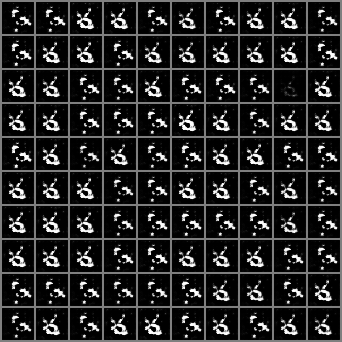

epoch: 1/10, batch: 410/600, G_loss: 2.329718589782715, D_loss: (0.1010446771979332, 0.10518288612365723)
epoch: 1/10, batch: 420/600, G_loss: 2.133819341659546, D_loss: (0.10608917474746704, 0.1303195059299469)
epoch: 1/10, batch: 430/600, G_loss: 3.1243395805358887, D_loss: (0.06249728798866272, 0.05560939013957977)
epoch: 1/10, batch: 440/600, G_loss: 2.2332496643066406, D_loss: (0.05815725028514862, 0.1166139617562294)
epoch: 1/10, batch: 450/600, G_loss: 4.32319450378418, D_loss: (0.04814032465219498, 0.05542382597923279)
epoch: 1/10, batch: 460/600, G_loss: 2.5106170177459717, D_loss: (0.08840205520391464, 0.10575606673955917)
epoch: 1/10, batch: 470/600, G_loss: 2.9959769248962402, D_loss: (0.047623615711927414, 0.07125277072191238)
epoch: 1/10, batch: 480/600, G_loss: 2.8302698135375977, D_loss: (0.1401054710149765, 0.09373749792575836)
epoch: 1/10, batch: 490/600, G_loss: 3.350706100463867, D_loss: (0.08018766343593597, 0.0445190966129303)
epoch: 1/10, batch: 500/600, G_loss: 

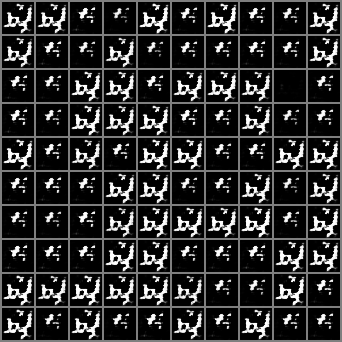

epoch: 1/10, batch: 510/600, G_loss: 3.442199945449829, D_loss: (0.032386068254709244, 0.034889981150627136)
epoch: 1/10, batch: 520/600, G_loss: 3.1385979652404785, D_loss: (0.019486231729388237, 0.046131573617458344)
epoch: 1/10, batch: 530/600, G_loss: 2.6159861087799072, D_loss: (0.020577695220708847, 0.20839759707450867)
epoch: 1/10, batch: 540/600, G_loss: 7.567354679107666, D_loss: (1.3869531154632568, 0.0015384474536404014)
epoch: 1/10, batch: 550/600, G_loss: 2.676905632019043, D_loss: (0.1291375756263733, 0.07559792697429657)
epoch: 1/10, batch: 560/600, G_loss: 2.870817184448242, D_loss: (0.06790300458669662, 0.06080692633986473)
epoch: 1/10, batch: 570/600, G_loss: 4.5562920570373535, D_loss: (0.021262001246213913, 1.0753109455108643)
epoch: 1/10, batch: 580/600, G_loss: 2.9630019664764404, D_loss: (0.0467260517179966, 0.18673638999462128)
epoch: 1/10, batch: 590/600, G_loss: 4.028541088104248, D_loss: (0.073874332010746, 0.03519820049405098)
epoch: 2/10, batch: 0/600, G_lo

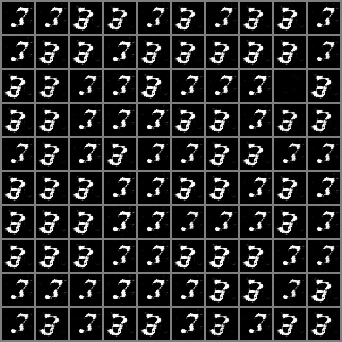

epoch: 2/10, batch: 10/600, G_loss: 2.1937406063079834, D_loss: (0.08792828768491745, 0.12371081113815308)
epoch: 2/10, batch: 20/600, G_loss: 2.6467936038970947, D_loss: (0.08602184057235718, 0.07439937442541122)
epoch: 2/10, batch: 30/600, G_loss: 2.707443952560425, D_loss: (0.03983060270547867, 0.08237692713737488)
epoch: 2/10, batch: 40/600, G_loss: 2.2738897800445557, D_loss: (0.04702344909310341, 0.11622326821088791)
epoch: 2/10, batch: 50/600, G_loss: 5.143568515777588, D_loss: (0.0584312342107296, 0.05777742341160774)
epoch: 2/10, batch: 60/600, G_loss: 3.2123379707336426, D_loss: (0.13423751294612885, 0.04158811271190643)
epoch: 2/10, batch: 70/600, G_loss: 2.821169853210449, D_loss: (0.06795397400856018, 0.06259951740503311)
epoch: 2/10, batch: 80/600, G_loss: 2.805546283721924, D_loss: (0.0722850114107132, 0.06313908845186234)
epoch: 2/10, batch: 90/600, G_loss: 3.493419885635376, D_loss: (0.03221999108791351, 0.03185384348034859)
epoch: 2/10, batch: 100/600, G_loss: 9.53274

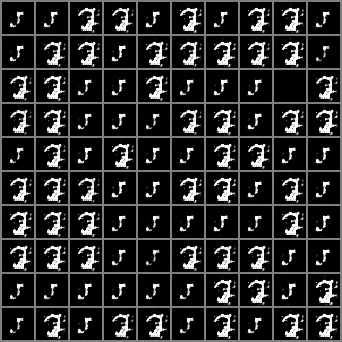

epoch: 2/10, batch: 110/600, G_loss: 2.4988908767700195, D_loss: (0.01720290258526802, 0.08688788115978241)
epoch: 2/10, batch: 120/600, G_loss: 2.618253707885742, D_loss: (0.01120136771351099, 0.21446800231933594)
epoch: 2/10, batch: 130/600, G_loss: 6.1385040283203125, D_loss: (0.12999726831912994, 0.003818274475634098)
epoch: 2/10, batch: 140/600, G_loss: 1.7975795269012451, D_loss: (0.16802290081977844, 0.1851438581943512)
epoch: 2/10, batch: 150/600, G_loss: 3.1281626224517822, D_loss: (0.044468317180871964, 0.05088121443986893)
epoch: 2/10, batch: 160/600, G_loss: 5.903402805328369, D_loss: (0.14727479219436646, 0.004332804121077061)
epoch: 2/10, batch: 170/600, G_loss: 1.3047208786010742, D_loss: (0.09066510200500488, 0.3352859914302826)
epoch: 2/10, batch: 180/600, G_loss: 4.729947566986084, D_loss: (0.136508047580719, 0.012082037515938282)
epoch: 2/10, batch: 190/600, G_loss: 2.1496098041534424, D_loss: (0.05993586406111717, 0.13449937105178833)
epoch: 2/10, batch: 200/600, G_

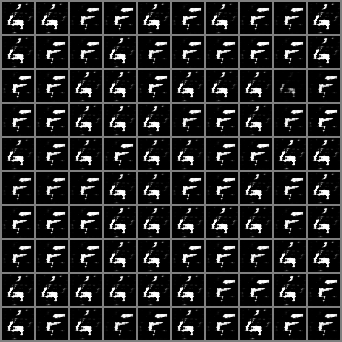

epoch: 2/10, batch: 210/600, G_loss: 3.289738178253174, D_loss: (0.0793384462594986, 0.03867112100124359)
epoch: 2/10, batch: 220/600, G_loss: 3.570185899734497, D_loss: (0.047721486538648605, 0.028897615149617195)
epoch: 2/10, batch: 230/600, G_loss: 2.3092591762542725, D_loss: (0.021007178351283073, 0.11234831809997559)
epoch: 2/10, batch: 240/600, G_loss: 2.992055654525757, D_loss: (0.12226909399032593, 0.0532059483230114)
epoch: 2/10, batch: 250/600, G_loss: 4.809779167175293, D_loss: (0.05652599781751633, 0.010901437141001225)
epoch: 2/10, batch: 260/600, G_loss: 4.380988121032715, D_loss: (0.1020577922463417, 0.01509530283510685)
epoch: 2/10, batch: 270/600, G_loss: 3.228273868560791, D_loss: (0.0718877762556076, 0.046075526624917984)
epoch: 2/10, batch: 280/600, G_loss: 1.335046648979187, D_loss: (0.0012919600121676922, 1.8820308446884155)
epoch: 2/10, batch: 290/600, G_loss: 3.0610005855560303, D_loss: (0.1648329496383667, 0.05003684386610985)
epoch: 2/10, batch: 300/600, G_los

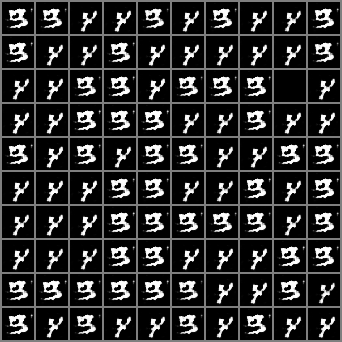

epoch: 2/10, batch: 310/600, G_loss: 3.30802583694458, D_loss: (0.07418283820152283, 0.04427218437194824)
epoch: 2/10, batch: 320/600, G_loss: 2.4701180458068848, D_loss: (0.04023625701665878, 0.0991334468126297)
epoch: 2/10, batch: 330/600, G_loss: 10.026278495788574, D_loss: (1.0144084692001343, 0.0014514658832922578)
epoch: 2/10, batch: 340/600, G_loss: 2.452754259109497, D_loss: (0.08380620181560516, 0.09750853478908539)
epoch: 2/10, batch: 350/600, G_loss: 2.4775657653808594, D_loss: (0.08754916489124298, 0.1022966131567955)
epoch: 2/10, batch: 360/600, G_loss: 2.6101903915405273, D_loss: (0.053847454488277435, 0.08956598490476608)
epoch: 2/10, batch: 370/600, G_loss: 3.9602789878845215, D_loss: (0.06387749314308167, 0.019724855199456215)
epoch: 2/10, batch: 380/600, G_loss: 3.7957763671875, D_loss: (0.1447412222623825, 0.025418486446142197)
epoch: 2/10, batch: 390/600, G_loss: 3.699639320373535, D_loss: (0.029685793444514275, 0.031110553070902824)
epoch: 2/10, batch: 400/600, G_l

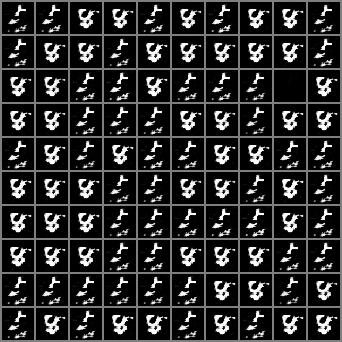

epoch: 2/10, batch: 410/600, G_loss: 5.945188045501709, D_loss: (0.027547039091587067, 0.011513954028487206)
epoch: 2/10, batch: 420/600, G_loss: 4.290729522705078, D_loss: (0.15494680404663086, 0.016975516453385353)
epoch: 2/10, batch: 430/600, G_loss: 3.584789752960205, D_loss: (0.04909388720989227, 0.029764458537101746)
epoch: 2/10, batch: 440/600, G_loss: 5.622964859008789, D_loss: (0.004700636491179466, 0.5036347508430481)
epoch: 2/10, batch: 450/600, G_loss: 1.7452605962753296, D_loss: (0.2934918701648712, 0.24833309650421143)
epoch: 2/10, batch: 460/600, G_loss: 2.1262094974517822, D_loss: (0.06002539023756981, 0.14318297803401947)
epoch: 2/10, batch: 470/600, G_loss: 2.2311699390411377, D_loss: (0.08771494776010513, 0.11620236188173294)
epoch: 2/10, batch: 480/600, G_loss: 8.74374771118164, D_loss: (1.4296423196792603, 0.0003599652263801545)
epoch: 2/10, batch: 490/600, G_loss: 2.288148880004883, D_loss: (0.16704238951206207, 0.15364116430282593)
epoch: 2/10, batch: 500/600, G_

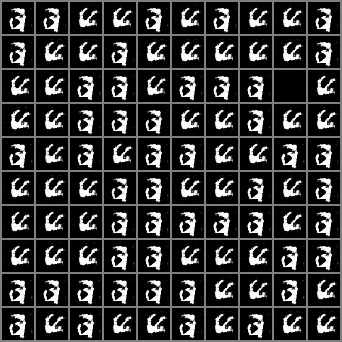

epoch: 2/10, batch: 510/600, G_loss: 8.779581069946289, D_loss: (0.1570759266614914, 0.01055808737874031)
epoch: 2/10, batch: 520/600, G_loss: 3.0321619510650635, D_loss: (0.045138534158468246, 0.0589277520775795)
epoch: 2/10, batch: 530/600, G_loss: 2.7370522022247314, D_loss: (0.0633719339966774, 0.10531499981880188)
epoch: 2/10, batch: 540/600, G_loss: 2.9760870933532715, D_loss: (0.03670375421643257, 0.057367611676454544)
epoch: 2/10, batch: 550/600, G_loss: 4.706611156463623, D_loss: (0.06576909124851227, 0.014157688245177269)
epoch: 2/10, batch: 560/600, G_loss: 2.2962687015533447, D_loss: (0.0611981526017189, 0.15103283524513245)
epoch: 2/10, batch: 570/600, G_loss: 4.175195217132568, D_loss: (0.030979806557297707, 0.027110712602734566)
epoch: 2/10, batch: 580/600, G_loss: 1.8329176902770996, D_loss: (0.051583051681518555, 0.18688993155956268)
epoch: 2/10, batch: 590/600, G_loss: 2.5373101234436035, D_loss: (0.07759218662977219, 0.09309369325637817)
epoch: 3/10, batch: 0/600, G_

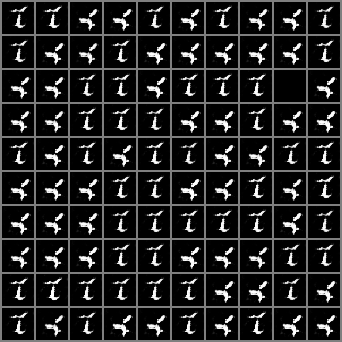

epoch: 3/10, batch: 10/600, G_loss: 2.822216749191284, D_loss: (0.08074626326560974, 0.06280752271413803)
epoch: 3/10, batch: 20/600, G_loss: 3.141815185546875, D_loss: (0.14292363822460175, 0.044361818581819534)
epoch: 3/10, batch: 30/600, G_loss: 2.2718558311462402, D_loss: (0.057980261743068695, 0.12425630539655685)
epoch: 3/10, batch: 40/600, G_loss: 2.972721576690674, D_loss: (0.03807074576616287, 0.05795622244477272)
epoch: 3/10, batch: 50/600, G_loss: 3.8161559104919434, D_loss: (0.07457419484853745, 0.02364957146346569)
epoch: 3/10, batch: 60/600, G_loss: 4.496884822845459, D_loss: (0.009076899848878384, 0.08478086441755295)
epoch: 3/10, batch: 70/600, G_loss: 10.172582626342773, D_loss: (0.293050080537796, 0.00022985524265095592)
epoch: 3/10, batch: 80/600, G_loss: 3.8382396697998047, D_loss: (0.09143921732902527, 0.06247605383396149)
epoch: 3/10, batch: 90/600, G_loss: 3.489006757736206, D_loss: (0.036795724183321, 0.03505430743098259)
epoch: 3/10, batch: 100/600, G_loss: 3.3

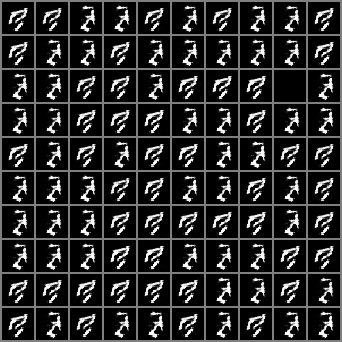

epoch: 3/10, batch: 110/600, G_loss: 2.201634168624878, D_loss: (0.002331445226445794, 0.14134615659713745)
epoch: 3/10, batch: 120/600, G_loss: 4.073923110961914, D_loss: (0.1807112842798233, 0.019872937351465225)
epoch: 3/10, batch: 130/600, G_loss: 4.335299968719482, D_loss: (0.20464922487735748, 0.014365527778863907)
epoch: 3/10, batch: 140/600, G_loss: 2.7547833919525146, D_loss: (0.03592674806714058, 0.06636350601911545)
epoch: 3/10, batch: 150/600, G_loss: 2.500447988510132, D_loss: (0.024189788848161697, 0.12254433333873749)
epoch: 3/10, batch: 160/600, G_loss: 4.866145133972168, D_loss: (0.08872188627719879, 0.007945316843688488)
epoch: 3/10, batch: 170/600, G_loss: 3.7234649658203125, D_loss: (0.02790222130715847, 0.025491802021861076)
epoch: 3/10, batch: 180/600, G_loss: 2.2978696823120117, D_loss: (0.028756825253367424, 0.14391377568244934)
epoch: 3/10, batch: 190/600, G_loss: 3.788048505783081, D_loss: (0.056069545447826385, 0.024695105850696564)
epoch: 3/10, batch: 200/60

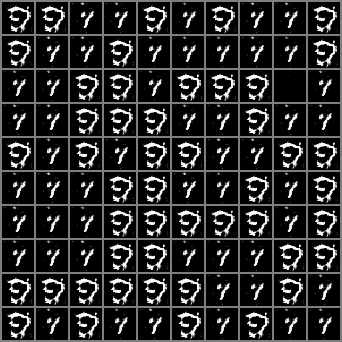

epoch: 3/10, batch: 210/600, G_loss: 3.7629263401031494, D_loss: (0.04382938891649246, 0.04141085222363472)
epoch: 3/10, batch: 220/600, G_loss: 2.619990825653076, D_loss: (0.02388671226799488, 0.07736796885728836)
epoch: 3/10, batch: 230/600, G_loss: 7.7958855628967285, D_loss: (0.4168259799480438, 0.03174800053238869)
epoch: 3/10, batch: 240/600, G_loss: 2.7894954681396484, D_loss: (0.026717402040958405, 0.1185920313000679)
epoch: 3/10, batch: 250/600, G_loss: 2.856562852859497, D_loss: (0.017086807638406754, 0.07134363055229187)
epoch: 3/10, batch: 260/600, G_loss: 3.563100814819336, D_loss: (0.016163164749741554, 0.033243514597415924)
epoch: 3/10, batch: 270/600, G_loss: 3.326977252960205, D_loss: (0.05581706017255783, 0.04295274615287781)
epoch: 3/10, batch: 280/600, G_loss: 2.7957775592803955, D_loss: (0.06777290999889374, 0.08202839642763138)
epoch: 3/10, batch: 290/600, G_loss: 4.2346906661987305, D_loss: (0.038114532828330994, 0.01717020384967327)
epoch: 3/10, batch: 300/600, 

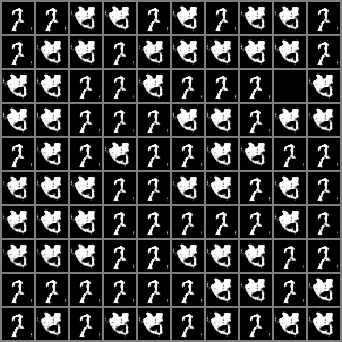

epoch: 3/10, batch: 310/600, G_loss: 1.3518977165222168, D_loss: (0.03944528475403786, 0.32157471776008606)
epoch: 3/10, batch: 320/600, G_loss: 2.3083648681640625, D_loss: (0.010351210832595825, 0.254367470741272)
epoch: 3/10, batch: 330/600, G_loss: 3.234593152999878, D_loss: (0.12102878838777542, 0.057171277701854706)
epoch: 3/10, batch: 340/600, G_loss: 6.332479953765869, D_loss: (0.027381401509046555, 0.045866433531045914)
epoch: 3/10, batch: 350/600, G_loss: 2.9552700519561768, D_loss: (0.04678209871053696, 0.06270760297775269)
epoch: 3/10, batch: 360/600, G_loss: 3.6790692806243896, D_loss: (0.026953229680657387, 0.026486584916710854)
epoch: 3/10, batch: 370/600, G_loss: 2.7948954105377197, D_loss: (0.012513495981693268, 0.07269252091646194)
epoch: 3/10, batch: 380/600, G_loss: 4.71635627746582, D_loss: (0.04261261597275734, 0.00905640795826912)
epoch: 3/10, batch: 390/600, G_loss: 2.401094675064087, D_loss: (0.03682437911629677, 0.10728046298027039)
epoch: 3/10, batch: 400/600,

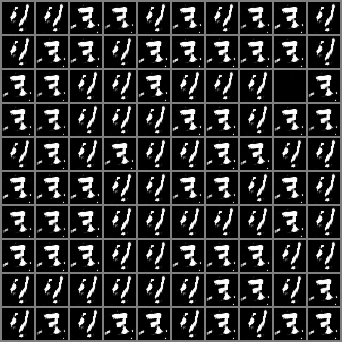

epoch: 3/10, batch: 410/600, G_loss: 3.4710781574249268, D_loss: (0.059370312839746475, 0.03713151067495346)
epoch: 3/10, batch: 420/600, G_loss: 3.051518440246582, D_loss: (0.014208637177944183, 0.09465309232473373)
epoch: 3/10, batch: 430/600, G_loss: 2.359560251235962, D_loss: (0.07993688434362411, 0.1150977686047554)
epoch: 3/10, batch: 440/600, G_loss: 3.816269874572754, D_loss: (0.01502743735909462, 0.023856937885284424)
epoch: 3/10, batch: 450/600, G_loss: 3.2134249210357666, D_loss: (0.05877864360809326, 0.04218306392431259)
epoch: 3/10, batch: 460/600, G_loss: 3.856199264526367, D_loss: (0.008808917365968227, 0.021669650450348854)
epoch: 3/10, batch: 470/600, G_loss: 2.3953211307525635, D_loss: (0.048078503459692, 0.09834460914134979)
epoch: 3/10, batch: 480/600, G_loss: 7.815258026123047, D_loss: (0.263827919960022, 0.00045312006841413677)
epoch: 3/10, batch: 490/600, G_loss: 4.513174533843994, D_loss: (0.06717780232429504, 0.021213239058852196)
epoch: 3/10, batch: 500/600, G

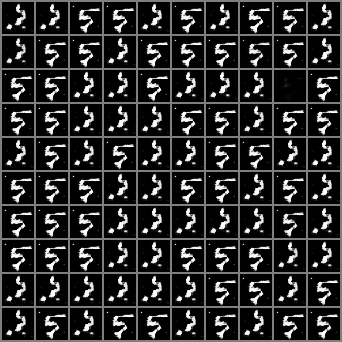

epoch: 3/10, batch: 510/600, G_loss: 3.3467254638671875, D_loss: (0.12406270205974579, 0.03665674850344658)
epoch: 3/10, batch: 520/600, G_loss: 3.518988847732544, D_loss: (0.04650544747710228, 0.03125024959445)
epoch: 3/10, batch: 530/600, G_loss: 3.6244306564331055, D_loss: (0.022787518799304962, 0.03227122128009796)
epoch: 3/10, batch: 540/600, G_loss: 3.0031158924102783, D_loss: (0.023653071373701096, 0.05138707160949707)
epoch: 3/10, batch: 550/600, G_loss: 3.0271942615509033, D_loss: (0.1424068957567215, 0.051238980144262314)
epoch: 3/10, batch: 560/600, G_loss: 3.9863288402557373, D_loss: (0.016144132241606712, 0.01917273923754692)
epoch: 3/10, batch: 570/600, G_loss: 3.7409610748291016, D_loss: (0.04716556519269943, 0.02554571069777012)
epoch: 3/10, batch: 580/600, G_loss: 7.464448928833008, D_loss: (0.004259202629327774, 0.021176056936383247)
epoch: 3/10, batch: 590/600, G_loss: 2.519742012023926, D_loss: (0.07979606837034225, 0.08723984658718109)
epoch: 4/10, batch: 0/600, G_

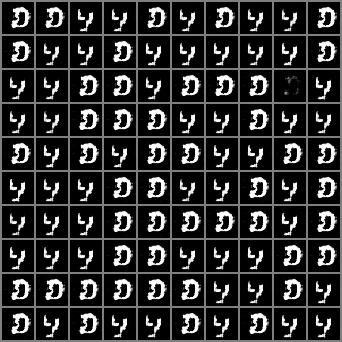

epoch: 4/10, batch: 10/600, G_loss: 4.491859436035156, D_loss: (0.01443502213805914, 0.011522292159497738)
epoch: 4/10, batch: 20/600, G_loss: 2.9960851669311523, D_loss: (0.0428287535905838, 0.05469498038291931)
epoch: 4/10, batch: 30/600, G_loss: 3.259122371673584, D_loss: (0.00637583713978529, 0.0506514348089695)
epoch: 4/10, batch: 40/600, G_loss: 5.08088493347168, D_loss: (0.17212633788585663, 0.006483399774879217)
epoch: 4/10, batch: 50/600, G_loss: 9.142596244812012, D_loss: (0.008148862048983574, 0.055627740919589996)
epoch: 4/10, batch: 60/600, G_loss: 4.823094367980957, D_loss: (0.07676086574792862, 0.0202676672488451)
epoch: 4/10, batch: 70/600, G_loss: 4.480649471282959, D_loss: (0.03558798134326935, 0.013059377670288086)
epoch: 4/10, batch: 80/600, G_loss: 4.3362812995910645, D_loss: (0.030884232372045517, 0.013326680287718773)
epoch: 4/10, batch: 90/600, G_loss: 2.5542383193969727, D_loss: (0.02347511053085327, 0.08592920005321503)
epoch: 4/10, batch: 100/600, G_loss: 3.6

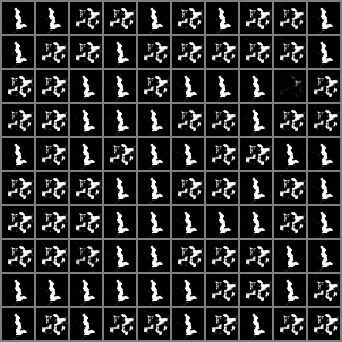

epoch: 4/10, batch: 110/600, G_loss: 3.9867136478424072, D_loss: (0.083819180727005, 0.02350611239671707)
epoch: 4/10, batch: 120/600, G_loss: 3.0747921466827393, D_loss: (0.015511976554989815, 0.0477222204208374)
epoch: 4/10, batch: 130/600, G_loss: 3.9194018840789795, D_loss: (0.03021412529051304, 0.020505249500274658)
epoch: 4/10, batch: 140/600, G_loss: 3.8431103229522705, D_loss: (0.09898915886878967, 0.023183975368738174)
epoch: 4/10, batch: 150/600, G_loss: 3.818368911743164, D_loss: (0.062138307839632034, 0.022432789206504822)
epoch: 4/10, batch: 160/600, G_loss: 2.933920383453369, D_loss: (0.022269345819950104, 0.06135243922472)
epoch: 4/10, batch: 170/600, G_loss: 4.258594989776611, D_loss: (0.08350363373756409, 0.01665724441409111)
epoch: 4/10, batch: 180/600, G_loss: 3.711515426635742, D_loss: (0.04854027181863785, 0.02508741430938244)
epoch: 4/10, batch: 190/600, G_loss: 2.7903308868408203, D_loss: (0.03273218497633934, 0.06340483576059341)
epoch: 4/10, batch: 200/600, G_l

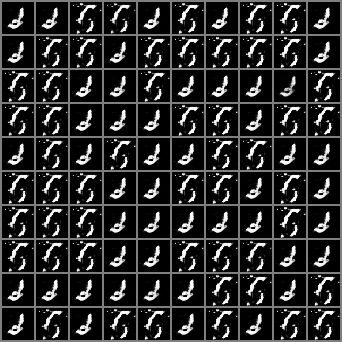

epoch: 4/10, batch: 210/600, G_loss: 3.4807851314544678, D_loss: (0.02661234140396118, 0.03423207625746727)
epoch: 4/10, batch: 220/600, G_loss: 3.3208487033843994, D_loss: (0.0629342570900917, 0.044005729258060455)
epoch: 4/10, batch: 230/600, G_loss: 3.248640537261963, D_loss: (0.04838283360004425, 0.048412829637527466)
epoch: 4/10, batch: 240/600, G_loss: 3.232837200164795, D_loss: (0.01082728523761034, 0.04063265770673752)
epoch: 4/10, batch: 250/600, G_loss: 3.817678451538086, D_loss: (0.005608073901385069, 0.022403638809919357)
epoch: 4/10, batch: 260/600, G_loss: 15.384459495544434, D_loss: (0.20780837535858154, 2.447407678118907e-05)
epoch: 4/10, batch: 270/600, G_loss: 2.688469886779785, D_loss: (0.0659390389919281, 0.07249605655670166)
epoch: 4/10, batch: 280/600, G_loss: 3.201592445373535, D_loss: (0.10049952566623688, 0.042796168476343155)
epoch: 4/10, batch: 290/600, G_loss: 3.6168532371520996, D_loss: (0.03426562249660492, 0.0306761022657156)
epoch: 4/10, batch: 300/600, 

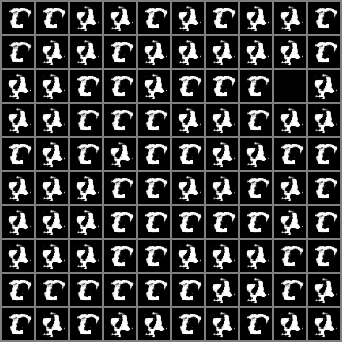

epoch: 4/10, batch: 310/600, G_loss: 4.22990608215332, D_loss: (0.016139116138219833, 0.01566491089761257)
epoch: 4/10, batch: 320/600, G_loss: 8.852400779724121, D_loss: (0.2465694397687912, 0.0006121171172708273)
epoch: 4/10, batch: 330/600, G_loss: 3.406341314315796, D_loss: (0.03338729590177536, 0.03971826285123825)
epoch: 4/10, batch: 340/600, G_loss: 3.8524093627929688, D_loss: (0.15913665294647217, 0.021677987650036812)
epoch: 4/10, batch: 350/600, G_loss: 4.809894561767578, D_loss: (0.09813481569290161, 0.012374984100461006)
epoch: 4/10, batch: 360/600, G_loss: 5.00346565246582, D_loss: (0.001090692006982863, 0.049455903470516205)
epoch: 4/10, batch: 370/600, G_loss: 7.1355791091918945, D_loss: (0.3182544410228729, 0.0028992909938097)
epoch: 4/10, batch: 380/600, G_loss: 2.797023296356201, D_loss: (0.06880088150501251, 0.07021033018827438)
epoch: 4/10, batch: 390/600, G_loss: 4.031921863555908, D_loss: (0.014622601680457592, 0.019597744569182396)
epoch: 4/10, batch: 400/600, G_

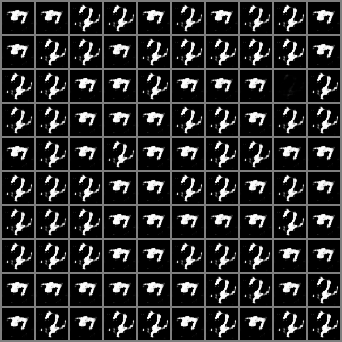

epoch: 4/10, batch: 410/600, G_loss: 3.6463863849639893, D_loss: (0.03478863090276718, 0.02710755541920662)
epoch: 4/10, batch: 420/600, G_loss: 3.9309885501861572, D_loss: (0.03347158432006836, 0.0219738706946373)
epoch: 4/10, batch: 430/600, G_loss: 4.663627624511719, D_loss: (0.13216839730739594, 0.023304425179958344)
epoch: 4/10, batch: 440/600, G_loss: 3.6637587547302246, D_loss: (0.04226630553603172, 0.027236128225922585)
epoch: 4/10, batch: 450/600, G_loss: 1.941686987876892, D_loss: (0.005084929522126913, 0.16888251900672913)
epoch: 4/10, batch: 460/600, G_loss: 5.8951334953308105, D_loss: (0.08797349780797958, 0.007416296750307083)
epoch: 4/10, batch: 470/600, G_loss: 6.705751419067383, D_loss: (0.039726752787828445, 0.004489462822675705)
epoch: 4/10, batch: 480/600, G_loss: 11.780800819396973, D_loss: (0.10913485288619995, 0.0036251014098525047)
epoch: 4/10, batch: 490/600, G_loss: 2.4542253017425537, D_loss: (0.09825702756643295, 0.10416997224092484)
epoch: 4/10, batch: 500/

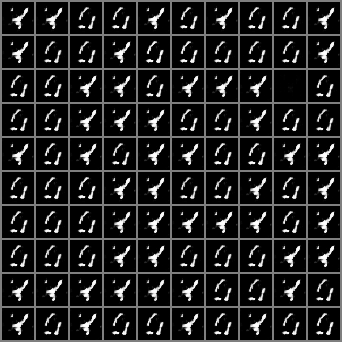

epoch: 4/10, batch: 510/600, G_loss: 4.177182674407959, D_loss: (0.10818830132484436, 0.028066955506801605)
epoch: 4/10, batch: 520/600, G_loss: 3.064319372177124, D_loss: (0.14200574159622192, 0.05610564723610878)
epoch: 4/10, batch: 530/600, G_loss: 3.4747366905212402, D_loss: (0.04305567219853401, 0.034442219883203506)
epoch: 4/10, batch: 540/600, G_loss: 2.9724204540252686, D_loss: (0.08344599604606628, 0.05293554440140724)
epoch: 4/10, batch: 550/600, G_loss: 3.2575290203094482, D_loss: (0.05917196720838547, 0.04431696981191635)
epoch: 4/10, batch: 560/600, G_loss: 2.256960391998291, D_loss: (0.09388266503810883, 0.17649993300437927)
epoch: 4/10, batch: 570/600, G_loss: 3.774526357650757, D_loss: (0.05303840711712837, 0.02406221441924572)
epoch: 4/10, batch: 580/600, G_loss: 3.6941466331481934, D_loss: (0.07160764932632446, 0.031681712716817856)
epoch: 4/10, batch: 590/600, G_loss: 4.0144829750061035, D_loss: (0.03454773500561714, 0.020386148244142532)
epoch: 5/10, batch: 0/600, G

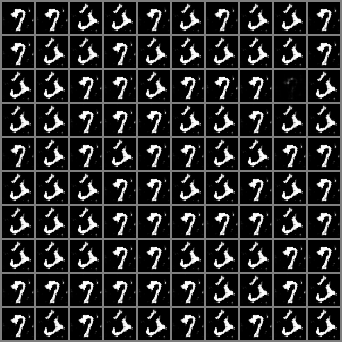

epoch: 5/10, batch: 10/600, G_loss: 6.143209934234619, D_loss: (0.14427481591701508, 0.010211962275207043)
epoch: 5/10, batch: 20/600, G_loss: 3.752246141433716, D_loss: (0.03185808286070824, 0.02610684558749199)
epoch: 5/10, batch: 30/600, G_loss: 4.040058135986328, D_loss: (0.027704879641532898, 0.018556581810116768)
epoch: 5/10, batch: 40/600, G_loss: 3.825390338897705, D_loss: (0.04728509485721588, 0.023567363619804382)
epoch: 5/10, batch: 50/600, G_loss: 4.423361301422119, D_loss: (0.03098505176603794, 0.012681014835834503)
epoch: 5/10, batch: 60/600, G_loss: 2.2045724391937256, D_loss: (0.021300505846738815, 0.12041565030813217)
epoch: 5/10, batch: 70/600, G_loss: 5.071150779724121, D_loss: (0.019561581313610077, 0.12619389593601227)
epoch: 5/10, batch: 80/600, G_loss: 4.011285305023193, D_loss: (0.040244512259960175, 0.018655553460121155)
epoch: 5/10, batch: 90/600, G_loss: 3.8650314807891846, D_loss: (0.05111352354288101, 0.02193206548690796)
epoch: 5/10, batch: 100/600, G_loss

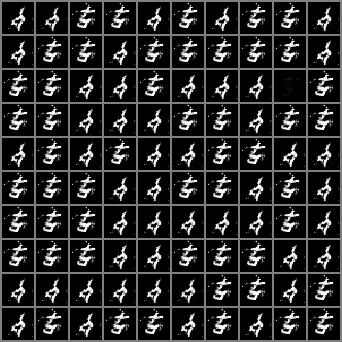

epoch: 5/10, batch: 110/600, G_loss: 5.1568989753723145, D_loss: (0.014733845368027687, 0.005787261296063662)
epoch: 5/10, batch: 120/600, G_loss: 7.361140727996826, D_loss: (0.0585126169025898, 0.002894969657063484)
epoch: 5/10, batch: 130/600, G_loss: 6.77970027923584, D_loss: (0.08598139882087708, 0.0016556797781959176)
epoch: 5/10, batch: 140/600, G_loss: 3.962322473526001, D_loss: (0.08308735489845276, 0.02183903008699417)
epoch: 5/10, batch: 150/600, G_loss: 3.629270315170288, D_loss: (0.04220381751656532, 0.035248052328825)
epoch: 5/10, batch: 160/600, G_loss: 3.1292331218719482, D_loss: (0.03713586926460266, 0.046137548983097076)
epoch: 5/10, batch: 170/600, G_loss: 3.642033338546753, D_loss: (0.04760735481977463, 0.02661219611763954)
epoch: 5/10, batch: 180/600, G_loss: 6.2524495124816895, D_loss: (0.14026780426502228, 0.00193173554725945)
epoch: 5/10, batch: 190/600, G_loss: 9.939652442932129, D_loss: (0.06125533580780029, 0.009867241606116295)
epoch: 5/10, batch: 200/600, G_

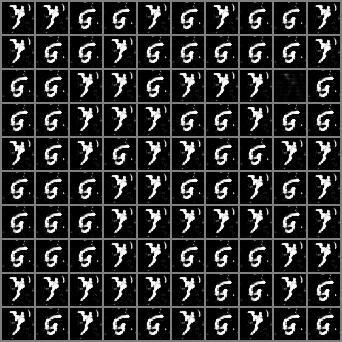

epoch: 5/10, batch: 210/600, G_loss: 2.4385979175567627, D_loss: (0.01158538181334734, 0.19486141204833984)
epoch: 5/10, batch: 220/600, G_loss: 3.1617090702056885, D_loss: (0.03224784508347511, 0.043470028787851334)
epoch: 5/10, batch: 230/600, G_loss: 4.636103630065918, D_loss: (0.01530164759606123, 0.009791332297027111)
epoch: 5/10, batch: 240/600, G_loss: 3.8523569107055664, D_loss: (0.033277735114097595, 0.024421893060207367)
epoch: 5/10, batch: 250/600, G_loss: 3.676964044570923, D_loss: (0.0932641476392746, 0.026376893743872643)
epoch: 5/10, batch: 260/600, G_loss: 3.2088325023651123, D_loss: (0.02777049131691456, 0.042116936296224594)
epoch: 5/10, batch: 270/600, G_loss: 3.812643527984619, D_loss: (0.023118890821933746, 0.022807342931628227)
epoch: 5/10, batch: 280/600, G_loss: 3.0073180198669434, D_loss: (0.020723309367895126, 0.05139871686697006)
epoch: 5/10, batch: 290/600, G_loss: 3.3993659019470215, D_loss: (0.06513526290655136, 0.0343710295855999)
epoch: 5/10, batch: 300/

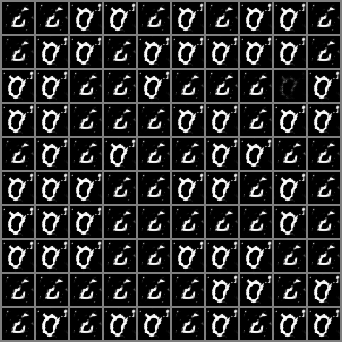

epoch: 5/10, batch: 310/600, G_loss: 3.9561867713928223, D_loss: (0.023271765559911728, 0.019588589668273926)
epoch: 5/10, batch: 320/600, G_loss: 4.618964195251465, D_loss: (0.024506356567144394, 0.01013015303760767)
epoch: 5/10, batch: 330/600, G_loss: 4.042001724243164, D_loss: (0.01905473694205284, 0.018218224868178368)
epoch: 5/10, batch: 340/600, G_loss: 4.611071586608887, D_loss: (0.032214999198913574, 0.01156683824956417)
epoch: 5/10, batch: 350/600, G_loss: 4.130720138549805, D_loss: (0.024135693907737732, 0.022619973868131638)
epoch: 5/10, batch: 360/600, G_loss: 3.7089385986328125, D_loss: (0.01650657132267952, 0.027383603155612946)
epoch: 5/10, batch: 370/600, G_loss: 3.027641534805298, D_loss: (0.0282841045409441, 0.05693824216723442)
epoch: 5/10, batch: 380/600, G_loss: 2.774064064025879, D_loss: (0.03673291206359863, 0.07420875132083893)
epoch: 5/10, batch: 390/600, G_loss: 8.732536315917969, D_loss: (0.4037255048751831, 0.0001727890776237473)
epoch: 5/10, batch: 400/600

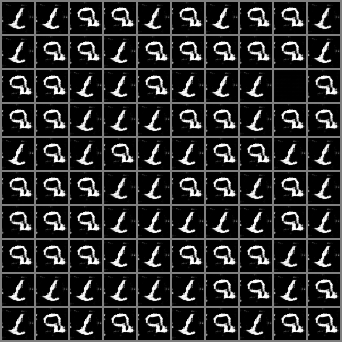

epoch: 5/10, batch: 410/600, G_loss: 8.726007461547852, D_loss: (0.49872884154319763, 0.002742380602285266)
epoch: 5/10, batch: 420/600, G_loss: 3.888801336288452, D_loss: (0.17421644926071167, 0.021842438727617264)
epoch: 5/10, batch: 430/600, G_loss: 4.335241794586182, D_loss: (0.03770178556442261, 0.024073250591754913)
epoch: 5/10, batch: 440/600, G_loss: 11.668269157409668, D_loss: (0.37799862027168274, 2.81592092505889e-05)
epoch: 5/10, batch: 450/600, G_loss: 1.7204128503799438, D_loss: (0.012427128851413727, 0.21462492644786835)
epoch: 5/10, batch: 460/600, G_loss: 7.205633163452148, D_loss: (0.033297762274742126, 0.0017393373418599367)
epoch: 5/10, batch: 470/600, G_loss: 4.066514492034912, D_loss: (0.12999659776687622, 0.021396541967988014)
epoch: 5/10, batch: 480/600, G_loss: 4.360385417938232, D_loss: (0.0732627883553505, 0.013024463318288326)
epoch: 5/10, batch: 490/600, G_loss: 3.141127586364746, D_loss: (0.058287572115659714, 0.0484214648604393)
epoch: 5/10, batch: 500/60

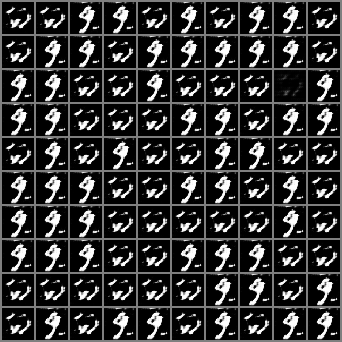

epoch: 5/10, batch: 510/600, G_loss: 2.130105495452881, D_loss: (0.012874138541519642, 0.1289447546005249)
epoch: 5/10, batch: 520/600, G_loss: 4.781498908996582, D_loss: (0.007413845509290695, 0.00943831168115139)
epoch: 5/10, batch: 530/600, G_loss: 4.358076095581055, D_loss: (0.062251824885606766, 0.014072990044951439)
epoch: 5/10, batch: 540/600, G_loss: 3.475172758102417, D_loss: (0.19063100218772888, 0.03277406841516495)
epoch: 5/10, batch: 550/600, G_loss: 11.959760665893555, D_loss: (0.014310614205896854, 0.0007093736785463989)
epoch: 5/10, batch: 560/600, G_loss: 2.761495351791382, D_loss: (0.015173008665442467, 0.07089337706565857)
epoch: 5/10, batch: 570/600, G_loss: 3.471665143966675, D_loss: (0.0636221170425415, 0.03237355127930641)
epoch: 5/10, batch: 580/600, G_loss: 3.302471399307251, D_loss: (0.09379680454730988, 0.03795313835144043)
epoch: 5/10, batch: 590/600, G_loss: 4.551297664642334, D_loss: (0.10087527334690094, 0.010825212113559246)
epoch: 6/10, batch: 0/600, G_

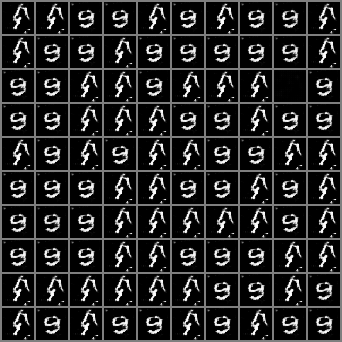

epoch: 6/10, batch: 10/600, G_loss: 3.4054901599884033, D_loss: (0.17632271349430084, 0.03741295263171196)
epoch: 6/10, batch: 20/600, G_loss: 3.2000560760498047, D_loss: (0.04250458627939224, 0.0747225433588028)
epoch: 6/10, batch: 30/600, G_loss: 1.473146677017212, D_loss: (0.0003157969331368804, 0.2905535399913788)
epoch: 6/10, batch: 40/600, G_loss: 3.0282468795776367, D_loss: (0.005212509538978338, 0.05135786533355713)
epoch: 6/10, batch: 50/600, G_loss: 4.372605800628662, D_loss: (0.03299505636096001, 0.013605390675365925)
epoch: 6/10, batch: 60/600, G_loss: 3.4323830604553223, D_loss: (0.15094925463199615, 0.04101422801613808)
epoch: 6/10, batch: 70/600, G_loss: 2.8053383827209473, D_loss: (0.05734003707766533, 0.07311341166496277)
epoch: 6/10, batch: 80/600, G_loss: 3.674321174621582, D_loss: (0.026109445840120316, 0.03623276203870773)
epoch: 6/10, batch: 90/600, G_loss: 3.8067712783813477, D_loss: (0.01460585743188858, 0.038122035562992096)
epoch: 6/10, batch: 100/600, G_loss:

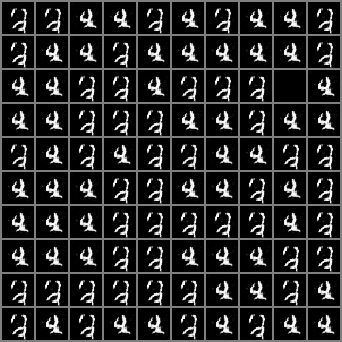

epoch: 6/10, batch: 110/600, G_loss: 4.037784576416016, D_loss: (0.031360939145088196, 0.018193254247307777)
epoch: 6/10, batch: 120/600, G_loss: 4.507809162139893, D_loss: (0.03645792603492737, 0.011521228589117527)
epoch: 6/10, batch: 130/600, G_loss: 4.667281150817871, D_loss: (0.021476268768310547, 0.009868445806205273)
epoch: 6/10, batch: 140/600, G_loss: 3.88740611076355, D_loss: (0.007795518264174461, 0.023667937144637108)
epoch: 6/10, batch: 150/600, G_loss: 3.408618211746216, D_loss: (0.027992889285087585, 0.037127405405044556)
epoch: 6/10, batch: 160/600, G_loss: 4.5768866539001465, D_loss: (0.05517904460430145, 0.011184489354491234)
epoch: 6/10, batch: 170/600, G_loss: 4.0761189460754395, D_loss: (0.026157917454838753, 0.017527982592582703)
epoch: 6/10, batch: 180/600, G_loss: 4.196352005004883, D_loss: (0.020293135195970535, 0.01688837818801403)
epoch: 6/10, batch: 190/600, G_loss: 1.796688437461853, D_loss: (0.002166306832805276, 0.19118903577327728)
epoch: 6/10, batch: 20

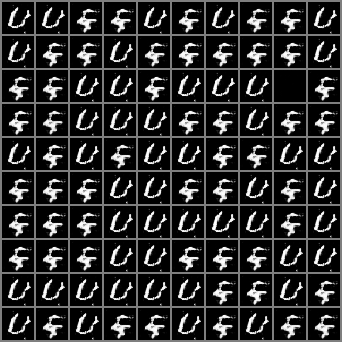

epoch: 6/10, batch: 210/600, G_loss: 2.335082530975342, D_loss: (0.06237364932894707, 0.10386422276496887)
epoch: 6/10, batch: 220/600, G_loss: 3.658372163772583, D_loss: (0.028263919055461884, 0.027148734778165817)
epoch: 6/10, batch: 230/600, G_loss: 3.3537778854370117, D_loss: (0.034728407859802246, 0.039033833891153336)
epoch: 6/10, batch: 240/600, G_loss: 4.789410591125488, D_loss: (0.019486669450998306, 0.00861632265150547)
epoch: 6/10, batch: 250/600, G_loss: 6.502443790435791, D_loss: (0.021580178290605545, 0.0018261082004755735)
epoch: 6/10, batch: 260/600, G_loss: 2.7470459938049316, D_loss: (0.033431023359298706, 0.08557075262069702)
epoch: 6/10, batch: 270/600, G_loss: 18.87892723083496, D_loss: (0.10133824497461319, 1.85624448931776e-05)
epoch: 6/10, batch: 280/600, G_loss: 2.0689804553985596, D_loss: (0.021713435649871826, 0.18831323087215424)
epoch: 6/10, batch: 290/600, G_loss: 10.917922019958496, D_loss: (0.40019363164901733, 0.000678098585922271)
epoch: 6/10, batch: 3

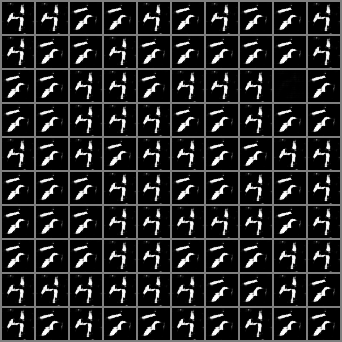

epoch: 6/10, batch: 310/600, G_loss: 3.370149612426758, D_loss: (0.011745933443307877, 0.03534218668937683)
epoch: 6/10, batch: 320/600, G_loss: 3.28989315032959, D_loss: (0.019197359681129456, 0.04056519642472267)
epoch: 6/10, batch: 330/600, G_loss: 3.6680526733398438, D_loss: (0.03438745066523552, 0.02839764766395092)
epoch: 6/10, batch: 340/600, G_loss: 3.880486488342285, D_loss: (0.007191270589828491, 0.02324586920440197)
epoch: 6/10, batch: 350/600, G_loss: 4.004308700561523, D_loss: (0.025711627677083015, 0.01859442889690399)
epoch: 6/10, batch: 360/600, G_loss: 4.433791637420654, D_loss: (0.03779955953359604, 0.012054556980729103)
epoch: 6/10, batch: 370/600, G_loss: 4.460023403167725, D_loss: (0.03241497650742531, 0.0117617417126894)
epoch: 6/10, batch: 380/600, G_loss: 4.447042942047119, D_loss: (0.013149882666766644, 0.012570876628160477)
epoch: 6/10, batch: 390/600, G_loss: 5.948265552520752, D_loss: (0.05240093544125557, 0.006996493320912123)
epoch: 6/10, batch: 400/600, G

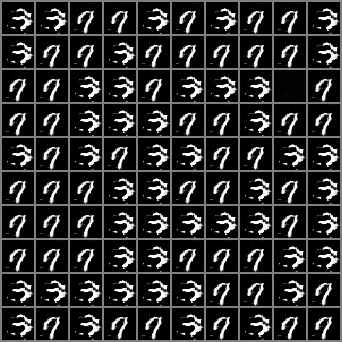

epoch: 6/10, batch: 410/600, G_loss: 4.048742771148682, D_loss: (0.013028554618358612, 0.017922986298799515)
epoch: 6/10, batch: 420/600, G_loss: 3.750453472137451, D_loss: (0.026695847511291504, 0.02475460059940815)
epoch: 6/10, batch: 430/600, G_loss: 3.749563217163086, D_loss: (0.02545747347176075, 0.02559337392449379)
epoch: 6/10, batch: 440/600, G_loss: 3.523411750793457, D_loss: (0.01021560188382864, 0.0312761627137661)
epoch: 6/10, batch: 450/600, G_loss: 5.378757476806641, D_loss: (0.013932649977505207, 0.1529279202222824)
epoch: 6/10, batch: 460/600, G_loss: 4.560605049133301, D_loss: (0.04079778492450714, 0.011003448627889156)
epoch: 6/10, batch: 470/600, G_loss: 5.010975360870361, D_loss: (0.023993467912077904, 0.0856756940484047)
epoch: 6/10, batch: 480/600, G_loss: 2.387223720550537, D_loss: (0.0059053231962025166, 0.12020190060138702)
epoch: 6/10, batch: 490/600, G_loss: 10.1638822555542, D_loss: (0.010341605171561241, 0.008021092042326927)
epoch: 6/10, batch: 500/600, G_

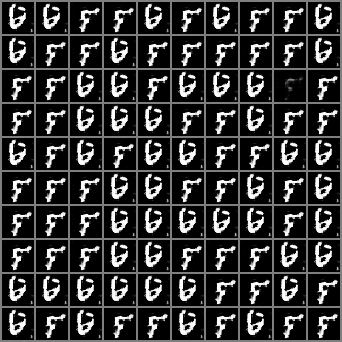

epoch: 6/10, batch: 510/600, G_loss: 3.8896596431732178, D_loss: (0.0750226378440857, 0.021185152232646942)
epoch: 6/10, batch: 520/600, G_loss: 2.982118606567383, D_loss: (0.04228568077087402, 0.06389650702476501)
epoch: 6/10, batch: 530/600, G_loss: 3.5237057209014893, D_loss: (0.07133287191390991, 0.03545347973704338)
epoch: 6/10, batch: 540/600, G_loss: 3.578782320022583, D_loss: (0.041944846510887146, 0.028343532234430313)
epoch: 6/10, batch: 550/600, G_loss: 3.9793028831481934, D_loss: (0.08573729544878006, 0.02058248035609722)
epoch: 6/10, batch: 560/600, G_loss: 3.667046546936035, D_loss: (0.06605532765388489, 0.02652755193412304)
epoch: 6/10, batch: 570/600, G_loss: 4.241440773010254, D_loss: (0.02636473812162876, 0.016055431216955185)
epoch: 6/10, batch: 580/600, G_loss: 3.7559967041015625, D_loss: (0.024191806092858315, 0.0254549328237772)
epoch: 6/10, batch: 590/600, G_loss: 4.642619609832764, D_loss: (0.05703862011432648, 0.00977171491831541)
epoch: 7/10, batch: 0/600, G_l

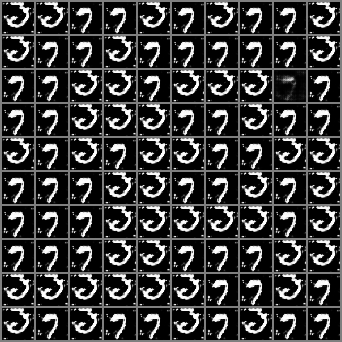

epoch: 7/10, batch: 10/600, G_loss: 3.9884328842163086, D_loss: (0.024905286729335785, 0.022851698100566864)
epoch: 7/10, batch: 20/600, G_loss: 2.6036009788513184, D_loss: (0.01356697641313076, 0.08557812869548798)
epoch: 7/10, batch: 30/600, G_loss: 5.839056491851807, D_loss: (0.11272703111171722, 0.04045581445097923)
epoch: 7/10, batch: 40/600, G_loss: 6.811094284057617, D_loss: (0.14850597083568573, 0.057923030108213425)
epoch: 7/10, batch: 50/600, G_loss: 2.7150909900665283, D_loss: (0.055940862745046616, 0.07125762104988098)
epoch: 7/10, batch: 60/600, G_loss: 4.696322917938232, D_loss: (0.011687789112329483, 0.017724962905049324)
epoch: 7/10, batch: 70/600, G_loss: 3.6640841960906982, D_loss: (0.019853372126817703, 0.029247112572193146)
epoch: 7/10, batch: 80/600, G_loss: 3.815948247909546, D_loss: (0.06825840473175049, 0.02409541606903076)
epoch: 7/10, batch: 90/600, G_loss: 4.105895519256592, D_loss: (0.05437535420060158, 0.01710590161383152)
epoch: 7/10, batch: 100/600, G_los

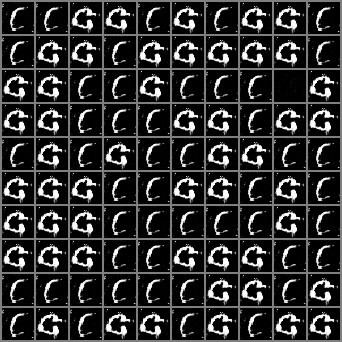

epoch: 7/10, batch: 110/600, G_loss: 2.549049139022827, D_loss: (0.08453848212957382, 0.09901558607816696)
epoch: 7/10, batch: 120/600, G_loss: 5.8972649574279785, D_loss: (0.05171100050210953, 0.015417171642184258)
epoch: 7/10, batch: 130/600, G_loss: 4.477783203125, D_loss: (0.0248386450111866, 0.012491203844547272)
epoch: 7/10, batch: 140/600, G_loss: 4.243635654449463, D_loss: (0.01909494958817959, 0.01730305142700672)
epoch: 7/10, batch: 150/600, G_loss: 5.6816630363464355, D_loss: (0.1054784506559372, 0.010094992816448212)
epoch: 7/10, batch: 160/600, G_loss: 3.5454185009002686, D_loss: (0.0570017546415329, 0.04024678096175194)
epoch: 7/10, batch: 170/600, G_loss: 17.196754455566406, D_loss: (0.013528659008443356, 0.00016846522339619696)
epoch: 7/10, batch: 180/600, G_loss: 5.080615520477295, D_loss: (0.054063644260168076, 0.009391102008521557)
epoch: 7/10, batch: 190/600, G_loss: 3.1812620162963867, D_loss: (0.0530129000544548, 0.04953888803720474)
epoch: 7/10, batch: 200/600, G

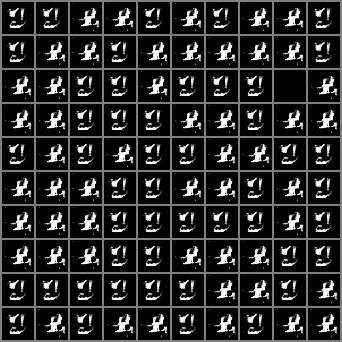

epoch: 7/10, batch: 210/600, G_loss: 4.65915060043335, D_loss: (0.02195676788687706, 0.010164252482354641)
epoch: 7/10, batch: 220/600, G_loss: 3.1936347484588623, D_loss: (0.03001466765999794, 0.04565105959773064)
epoch: 7/10, batch: 230/600, G_loss: 3.1446824073791504, D_loss: (0.05525573343038559, 0.04737592861056328)
epoch: 7/10, batch: 240/600, G_loss: 5.470988750457764, D_loss: (0.010557097382843494, 0.005600797012448311)
epoch: 7/10, batch: 250/600, G_loss: 3.715954303741455, D_loss: (0.01985415630042553, 0.027868634089827538)
epoch: 7/10, batch: 260/600, G_loss: 4.18294095993042, D_loss: (0.01783585362136364, 0.01631717011332512)
epoch: 7/10, batch: 270/600, G_loss: 4.282986640930176, D_loss: (0.024735666811466217, 0.01523263193666935)
epoch: 7/10, batch: 280/600, G_loss: 3.8934292793273926, D_loss: (0.03910943120718002, 0.020699892193078995)
epoch: 7/10, batch: 290/600, G_loss: 2.6560518741607666, D_loss: (0.01589617319405079, 0.08153834193944931)
epoch: 7/10, batch: 300/600, 

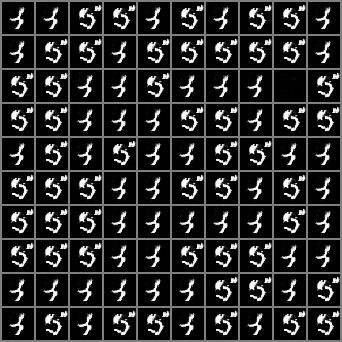

epoch: 7/10, batch: 310/600, G_loss: 6.276447296142578, D_loss: (6.148732063593343e-05, 0.010136893019080162)
epoch: 7/10, batch: 320/600, G_loss: 8.128068923950195, D_loss: (0.050042226910591125, 0.10553471744060516)
epoch: 7/10, batch: 330/600, G_loss: 2.4187581539154053, D_loss: (0.017300045117735863, 0.09757132828235626)
epoch: 7/10, batch: 340/600, G_loss: 5.60540771484375, D_loss: (0.00990445725619793, 0.00688813254237175)
epoch: 7/10, batch: 350/600, G_loss: 4.176767349243164, D_loss: (0.027819354087114334, 0.01607714220881462)
epoch: 7/10, batch: 360/600, G_loss: 5.910442352294922, D_loss: (0.11182243376970291, 0.0028479851316660643)
epoch: 7/10, batch: 370/600, G_loss: 2.4907641410827637, D_loss: (0.03469037637114525, 0.09010464698076248)
epoch: 7/10, batch: 380/600, G_loss: 1.7972944974899292, D_loss: (0.022433670237660408, 0.2156987339258194)
epoch: 7/10, batch: 390/600, G_loss: 5.193252086639404, D_loss: (0.010256124660372734, 0.01289000827819109)
epoch: 7/10, batch: 400/60

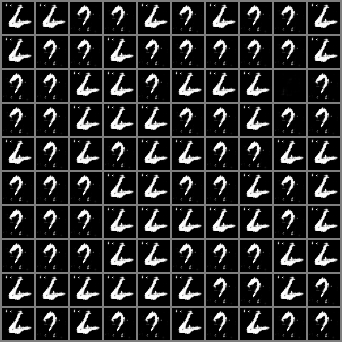

epoch: 7/10, batch: 410/600, G_loss: 3.642232656478882, D_loss: (0.016959773376584053, 0.028148841112852097)
epoch: 7/10, batch: 420/600, G_loss: 3.1201398372650146, D_loss: (0.02053425833582878, 0.047464799135923386)
epoch: 7/10, batch: 430/600, G_loss: 4.433370113372803, D_loss: (0.028927939012646675, 0.012721408158540726)
epoch: 7/10, batch: 440/600, G_loss: 4.98051118850708, D_loss: (0.03409995883703232, 0.007072271313518286)
epoch: 7/10, batch: 450/600, G_loss: 3.912607192993164, D_loss: (0.027090029790997505, 0.02144113928079605)
epoch: 7/10, batch: 460/600, G_loss: 3.284125566482544, D_loss: (0.1524028331041336, 0.03882787004113197)
epoch: 7/10, batch: 470/600, G_loss: 6.510550022125244, D_loss: (0.0038824807852506638, 0.0015443336451426148)
epoch: 7/10, batch: 480/600, G_loss: 2.6798949241638184, D_loss: (0.015552204102277756, 0.07263612002134323)
epoch: 7/10, batch: 490/600, G_loss: 3.635587692260742, D_loss: (0.009879623539745808, 0.027701253071427345)
epoch: 7/10, batch: 500

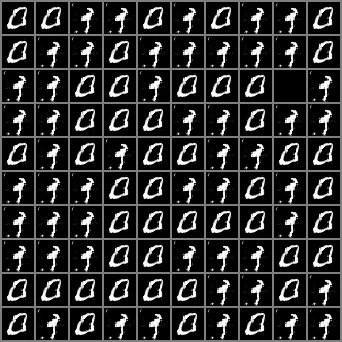

epoch: 7/10, batch: 510/600, G_loss: 3.7989182472229004, D_loss: (0.04184237867593765, 0.02270786464214325)
epoch: 7/10, batch: 520/600, G_loss: 3.7548933029174805, D_loss: (0.010683471336960793, 0.024049697443842888)
epoch: 7/10, batch: 530/600, G_loss: 4.384524345397949, D_loss: (0.03881340101361275, 0.01300320029258728)
epoch: 7/10, batch: 540/600, G_loss: 4.640622138977051, D_loss: (0.0623612105846405, 0.010210040025413036)
epoch: 7/10, batch: 550/600, G_loss: 4.660915851593018, D_loss: (0.007557351142168045, 0.012222829274833202)
epoch: 7/10, batch: 560/600, G_loss: 3.5576529502868652, D_loss: (0.023912804201245308, 0.03567089885473251)
epoch: 7/10, batch: 570/600, G_loss: 3.9190900325775146, D_loss: (0.016400445252656937, 0.03334878385066986)
epoch: 7/10, batch: 580/600, G_loss: 3.4686362743377686, D_loss: (0.011513547971844673, 0.036119721829891205)
epoch: 7/10, batch: 590/600, G_loss: 4.8400468826293945, D_loss: (0.03404770419001579, 0.008077925071120262)
epoch: 8/10, batch: 0/

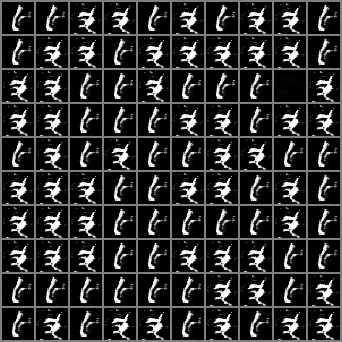

epoch: 8/10, batch: 10/600, G_loss: 3.8726577758789062, D_loss: (0.04099995642900467, 0.021885300055146217)
epoch: 8/10, batch: 20/600, G_loss: 2.34932017326355, D_loss: (0.04410077631473541, 0.10613003373146057)
epoch: 8/10, batch: 30/600, G_loss: 16.287132263183594, D_loss: (0.41105830669403076, 2.2434029233409092e-05)
epoch: 8/10, batch: 40/600, G_loss: 11.283452987670898, D_loss: (0.009936489164829254, 0.010042640380561352)
epoch: 8/10, batch: 50/600, G_loss: 11.270049095153809, D_loss: (1.6461519002914429, 0.00013012900308240205)
epoch: 8/10, batch: 60/600, G_loss: 7.140176773071289, D_loss: (0.028371179476380348, 0.0051526534371078014)
epoch: 8/10, batch: 70/600, G_loss: 3.010286808013916, D_loss: (0.022104652598500252, 0.05164356157183647)
epoch: 8/10, batch: 80/600, G_loss: 2.336702823638916, D_loss: (0.036683835089206696, 0.10274315625429153)
epoch: 8/10, batch: 90/600, G_loss: 3.9831087589263916, D_loss: (0.04832078889012337, 0.020005464553833008)
epoch: 8/10, batch: 100/600,

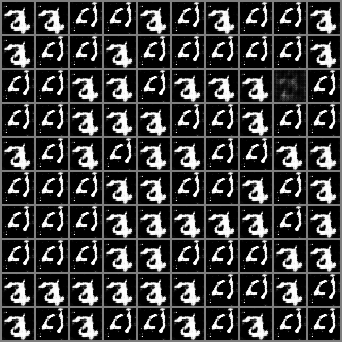

epoch: 8/10, batch: 110/600, G_loss: 4.045536994934082, D_loss: (0.0648709163069725, 0.018070131540298462)
epoch: 8/10, batch: 120/600, G_loss: 3.751241445541382, D_loss: (0.033421825617551804, 0.025504767894744873)
epoch: 8/10, batch: 130/600, G_loss: 2.917465925216675, D_loss: (0.019609343260526657, 0.059178322553634644)
epoch: 8/10, batch: 140/600, G_loss: 3.5298240184783936, D_loss: (0.028590060770511627, 0.03263736143708229)
epoch: 8/10, batch: 150/600, G_loss: 3.804142713546753, D_loss: (0.07251358032226562, 0.024246130138635635)
epoch: 8/10, batch: 160/600, G_loss: 3.158083915710449, D_loss: (0.07028274983167648, 0.04705563932657242)
epoch: 8/10, batch: 170/600, G_loss: 9.678672790527344, D_loss: (0.09172782301902771, 0.00017431793094146997)
epoch: 8/10, batch: 180/600, G_loss: 10.269701957702637, D_loss: (0.1877305805683136, 0.0001052488514687866)
epoch: 8/10, batch: 190/600, G_loss: 4.253683090209961, D_loss: (0.16494253277778625, 0.03597654774785042)
epoch: 8/10, batch: 200/6

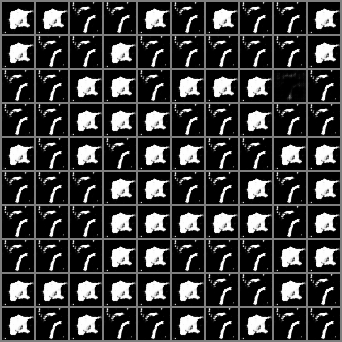

epoch: 8/10, batch: 210/600, G_loss: 3.6573691368103027, D_loss: (0.03545201197266579, 0.02670084685087204)
epoch: 8/10, batch: 220/600, G_loss: 4.5094122886657715, D_loss: (0.012239839881658554, 0.012223605066537857)
epoch: 8/10, batch: 230/600, G_loss: 3.250666618347168, D_loss: (0.01987498812377453, 0.04069056361913681)
epoch: 8/10, batch: 240/600, G_loss: 4.378082275390625, D_loss: (0.022206086665391922, 0.013235812075436115)
epoch: 8/10, batch: 250/600, G_loss: 3.5306801795959473, D_loss: (0.018340030685067177, 0.030533259734511375)
epoch: 8/10, batch: 260/600, G_loss: 4.3011980056762695, D_loss: (0.014360339380800724, 0.01728200726211071)
epoch: 8/10, batch: 270/600, G_loss: 3.9645767211914062, D_loss: (0.014251399785280228, 0.020412979647517204)
epoch: 8/10, batch: 280/600, G_loss: 9.229893684387207, D_loss: (0.05736883729696274, 0.0009650439606048167)
epoch: 8/10, batch: 290/600, G_loss: 4.735811233520508, D_loss: (0.13681459426879883, 0.19350434839725494)
epoch: 8/10, batch: 3

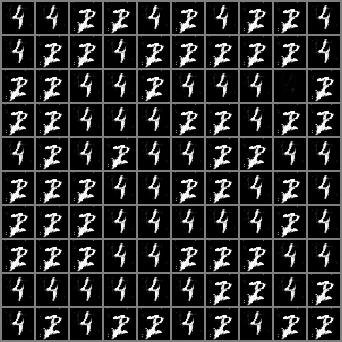

epoch: 8/10, batch: 310/600, G_loss: 13.833688735961914, D_loss: (0.12871448695659637, 2.3982493075891398e-05)
epoch: 8/10, batch: 320/600, G_loss: 3.6992244720458984, D_loss: (0.0520780049264431, 0.025171523913741112)
epoch: 8/10, batch: 330/600, G_loss: 3.701474666595459, D_loss: (0.07596360892057419, 0.02864370308816433)
epoch: 8/10, batch: 340/600, G_loss: 3.9707257747650146, D_loss: (0.06389022618532181, 0.01916719414293766)
epoch: 8/10, batch: 350/600, G_loss: 3.2897510528564453, D_loss: (0.06364835053682327, 0.038153063505887985)
epoch: 8/10, batch: 360/600, G_loss: 4.313685417175293, D_loss: (0.03345217555761337, 0.0135290352627635)
epoch: 8/10, batch: 370/600, G_loss: 2.203579902648926, D_loss: (0.008692375384271145, 0.12822586297988892)
epoch: 8/10, batch: 380/600, G_loss: 9.33310604095459, D_loss: (0.04473152756690979, 0.0003426159964874387)
epoch: 8/10, batch: 390/600, G_loss: 3.907810688018799, D_loss: (0.013238556683063507, 0.020725877955555916)
epoch: 8/10, batch: 400/60

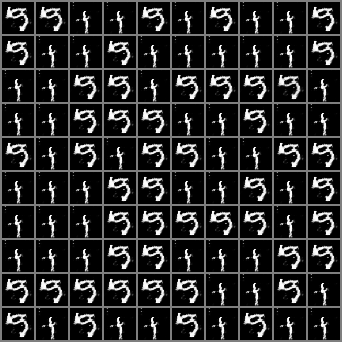

epoch: 8/10, batch: 410/600, G_loss: 4.063024520874023, D_loss: (0.0312567874789238, 0.017354317009449005)
epoch: 8/10, batch: 420/600, G_loss: 3.939074754714966, D_loss: (0.08046021312475204, 0.020009145140647888)
epoch: 8/10, batch: 430/600, G_loss: 4.3383870124816895, D_loss: (0.46582385897636414, 0.01720045506954193)
epoch: 8/10, batch: 440/600, G_loss: 8.578145980834961, D_loss: (0.02482057735323906, 0.04079429805278778)
epoch: 8/10, batch: 450/600, G_loss: 3.580594062805176, D_loss: (0.03790772333741188, 0.03717571869492531)
epoch: 8/10, batch: 460/600, G_loss: 4.5749359130859375, D_loss: (0.18876370787620544, 0.015237643383443356)
epoch: 8/10, batch: 470/600, G_loss: 3.0424671173095703, D_loss: (0.03371839597821236, 0.05151030048727989)
epoch: 8/10, batch: 480/600, G_loss: 5.917848110198975, D_loss: (0.06871050596237183, 0.02242683619260788)
epoch: 8/10, batch: 490/600, G_loss: 3.1358869075775146, D_loss: (0.1014142781496048, 0.044671837240457535)
epoch: 8/10, batch: 500/600, G_

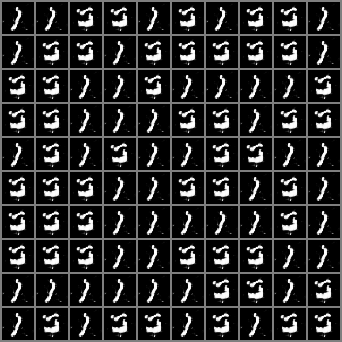

epoch: 8/10, batch: 510/600, G_loss: 3.5901358127593994, D_loss: (0.033297181129455566, 0.029442857950925827)
epoch: 8/10, batch: 520/600, G_loss: 3.6640610694885254, D_loss: (0.01923622190952301, 0.026119403541088104)
epoch: 8/10, batch: 530/600, G_loss: 3.117360830307007, D_loss: (0.04237084090709686, 0.045547809451818466)
epoch: 8/10, batch: 540/600, G_loss: 3.7019665241241455, D_loss: (0.045563917607069016, 0.026089010760188103)
epoch: 8/10, batch: 550/600, G_loss: 3.90042781829834, D_loss: (0.004592392593622208, 0.02069881744682789)
epoch: 8/10, batch: 560/600, G_loss: 4.556361198425293, D_loss: (0.008777700364589691, 0.010655958205461502)
epoch: 8/10, batch: 570/600, G_loss: 3.9187850952148438, D_loss: (0.024813279509544373, 0.020093226805329323)
epoch: 8/10, batch: 580/600, G_loss: 6.6307477951049805, D_loss: (0.16764450073242188, 0.0024089920334517956)
epoch: 8/10, batch: 590/600, G_loss: 5.833956718444824, D_loss: (0.012388940900564194, 0.022529236972332)
epoch: 9/10, batch: 0

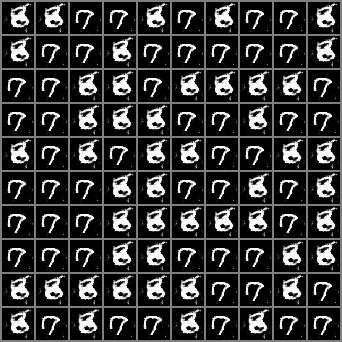

epoch: 9/10, batch: 10/600, G_loss: 4.621535778045654, D_loss: (0.061861347407102585, 0.010233724489808083)
epoch: 9/10, batch: 20/600, G_loss: 4.776978015899658, D_loss: (0.004869264550507069, 0.008701507933437824)
epoch: 9/10, batch: 30/600, G_loss: 4.437572956085205, D_loss: (0.046540021896362305, 0.012234811671078205)
epoch: 9/10, batch: 40/600, G_loss: 3.9277336597442627, D_loss: (0.018319226801395416, 0.020016534253954887)
epoch: 9/10, batch: 50/600, G_loss: 5.11073112487793, D_loss: (0.07080909609794617, 0.006164701655507088)
epoch: 9/10, batch: 60/600, G_loss: 4.607085227966309, D_loss: (0.0021275272592902184, 0.010096587240695953)
epoch: 9/10, batch: 70/600, G_loss: 8.865684509277344, D_loss: (0.5944713354110718, 0.0004522341478150338)
epoch: 9/10, batch: 80/600, G_loss: 8.638630867004395, D_loss: (0.0053214277140796185, 0.0005773978773504496)
epoch: 9/10, batch: 90/600, G_loss: 8.228996276855469, D_loss: (0.1161743700504303, 0.001750849885866046)
epoch: 9/10, batch: 100/600, 

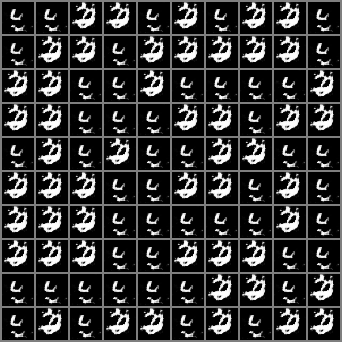

epoch: 9/10, batch: 110/600, G_loss: 2.9029977321624756, D_loss: (0.016553916037082672, 0.06042173504829407)
epoch: 9/10, batch: 120/600, G_loss: 10.417642593383789, D_loss: (0.00830843485891819, 0.008933392353355885)
epoch: 9/10, batch: 130/600, G_loss: 4.416146278381348, D_loss: (0.159452885389328, 0.04294905811548233)
epoch: 9/10, batch: 140/600, G_loss: 4.5994062423706055, D_loss: (0.03495340794324875, 0.010764376260340214)
epoch: 9/10, batch: 150/600, G_loss: 4.345611095428467, D_loss: (0.017499899491667747, 0.013216393068432808)
epoch: 9/10, batch: 160/600, G_loss: 3.7653872966766357, D_loss: (0.013371866196393967, 0.024723779410123825)
epoch: 9/10, batch: 170/600, G_loss: 3.8608462810516357, D_loss: (0.01624979078769684, 0.02128901518881321)
epoch: 9/10, batch: 180/600, G_loss: 7.189917087554932, D_loss: (2.5304509108536877e-05, 0.0007564579136669636)
epoch: 9/10, batch: 190/600, G_loss: 2.4324910640716553, D_loss: (0.0525171272456646, 0.14037999510765076)
epoch: 9/10, batch: 20

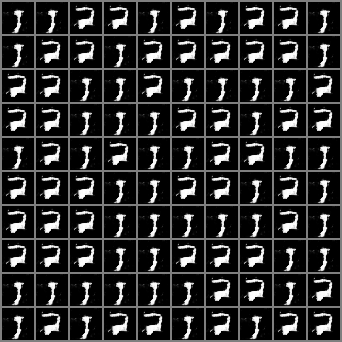

epoch: 9/10, batch: 210/600, G_loss: 4.617883682250977, D_loss: (0.10690926760435104, 0.029562048614025116)
epoch: 9/10, batch: 220/600, G_loss: 4.1131720542907715, D_loss: (0.044349122792482376, 0.016909832134842873)
epoch: 9/10, batch: 230/600, G_loss: 3.5300307273864746, D_loss: (0.02760615386068821, 0.030557505786418915)
epoch: 9/10, batch: 240/600, G_loss: 3.705808162689209, D_loss: (0.03463371470570564, 0.0250849612057209)
epoch: 9/10, batch: 250/600, G_loss: 3.7585208415985107, D_loss: (0.0323929488658905, 0.02583686262369156)
epoch: 9/10, batch: 260/600, G_loss: 3.1761820316314697, D_loss: (0.0427231639623642, 0.04459227994084358)
epoch: 9/10, batch: 270/600, G_loss: 4.4112725257873535, D_loss: (0.022260213270783424, 0.012248970568180084)
epoch: 9/10, batch: 280/600, G_loss: 3.442929744720459, D_loss: (0.010496365837752819, 0.07320783287286758)
epoch: 9/10, batch: 290/600, G_loss: 3.6172211170196533, D_loss: (0.05781496688723564, 0.028885729610919952)
epoch: 9/10, batch: 300/60

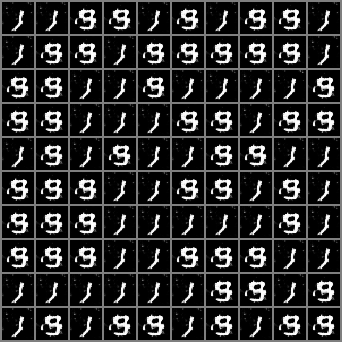

epoch: 9/10, batch: 310/600, G_loss: 3.0023181438446045, D_loss: (0.044552337378263474, 0.0693502426147461)
epoch: 9/10, batch: 320/600, G_loss: 3.574803113937378, D_loss: (0.08462520688772202, 0.04082069545984268)
epoch: 9/10, batch: 330/600, G_loss: 4.795283794403076, D_loss: (0.1384660303592682, 0.00843712966889143)
epoch: 9/10, batch: 340/600, G_loss: 4.092632293701172, D_loss: (0.011072894558310509, 0.01765192300081253)
epoch: 9/10, batch: 350/600, G_loss: 3.5303750038146973, D_loss: (0.03264831751585007, 0.029981715604662895)
epoch: 9/10, batch: 360/600, G_loss: 4.265905857086182, D_loss: (0.007568857632577419, 0.024773921817541122)
epoch: 9/10, batch: 370/600, G_loss: 4.449527740478516, D_loss: (0.0548466257750988, 0.012669051997363567)
epoch: 9/10, batch: 380/600, G_loss: 3.3644375801086426, D_loss: (0.009377777576446533, 0.037172671407461166)
epoch: 9/10, batch: 390/600, G_loss: 3.949756145477295, D_loss: (0.001096799154765904, 0.019845889881253242)
epoch: 9/10, batch: 400/600

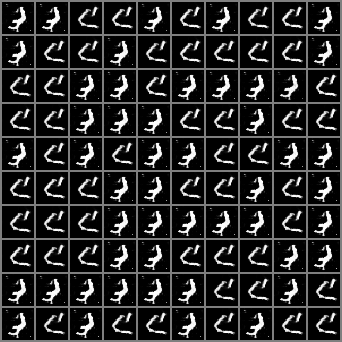

epoch: 9/10, batch: 410/600, G_loss: 4.337608814239502, D_loss: (0.08029106259346008, 0.013268526643514633)
epoch: 9/10, batch: 420/600, G_loss: 5.394911289215088, D_loss: (0.0012393302749842405, 0.015339498408138752)
epoch: 9/10, batch: 430/600, G_loss: 3.627506732940674, D_loss: (0.01360734086483717, 0.03275998681783676)
epoch: 9/10, batch: 440/600, G_loss: 2.9176928997039795, D_loss: (0.0119369151070714, 0.056170687079429626)
epoch: 9/10, batch: 450/600, G_loss: 3.9515950679779053, D_loss: (0.02440064027905464, 0.02086423896253109)
epoch: 9/10, batch: 460/600, G_loss: 9.054043769836426, D_loss: (0.07973610609769821, 0.00029989596805535257)
epoch: 9/10, batch: 470/600, G_loss: 4.472856044769287, D_loss: (0.02868817374110222, 0.01153969019651413)
epoch: 9/10, batch: 480/600, G_loss: 4.314800262451172, D_loss: (0.021490611135959625, 0.016150718554854393)
epoch: 9/10, batch: 490/600, G_loss: 3.985556125640869, D_loss: (0.07647264003753662, 0.018965398892760277)
epoch: 9/10, batch: 500/6

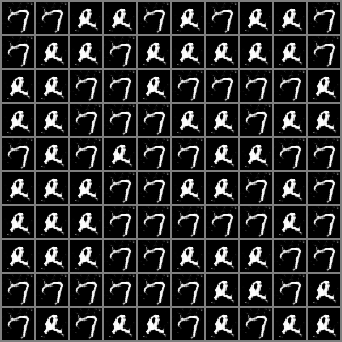

epoch: 9/10, batch: 510/600, G_loss: 7.903280735015869, D_loss: (0.0006533831474371254, 0.024945372715592384)
epoch: 9/10, batch: 520/600, G_loss: 4.934652328491211, D_loss: (0.1405894160270691, 0.029255593195557594)
epoch: 9/10, batch: 530/600, G_loss: 5.0205979347229, D_loss: (0.006168808322399855, 0.01572795957326889)
epoch: 9/10, batch: 540/600, G_loss: 3.866680383682251, D_loss: (0.045882776379585266, 0.02152358926832676)
epoch: 9/10, batch: 550/600, G_loss: 4.926669597625732, D_loss: (0.02920965664088726, 0.008032872341573238)
epoch: 9/10, batch: 560/600, G_loss: 4.235471725463867, D_loss: (0.03786672279238701, 0.014964274130761623)
epoch: 9/10, batch: 570/600, G_loss: 3.1266369819641113, D_loss: (0.04930659383535385, 0.04614613950252533)
epoch: 9/10, batch: 580/600, G_loss: 3.224280595779419, D_loss: (0.04070938006043434, 0.04216201603412628)
epoch: 9/10, batch: 590/600, G_loss: 3.8715624809265137, D_loss: (0.044154029339551926, 0.029018890112638474)


In [52]:
for epoch in range(num_epochs):
    for n_batch, (real_samples, labels) in enumerate(data_loader):
        
        real_samples = Variable(real_samples).cuda()
        labels1 = Variable(labels).cuda()

        loss_g, loss_d = model.step_optimization(real_samples, labels1)
        
        if (n_batch) % 10 == 0:
            print(f"epoch: {epoch}/{num_epochs}, batch: {n_batch}/{len(data_loader)}, G_loss: {loss_g}, D_loss: {loss_d}")    
          
        if (n_batch) % 100 == 0:
            val_fake_samples,_ = model.generate_samples(num_val_samples)
            display_batch_images(val_fake_samples)